In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import yaml

# Make notebook output cleaner
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Define project paths
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_RAW = ROOT / "data_raw"
DATA_PROC = ROOT / "data_processed"
CONFIG = ROOT / "config" / "settings.yaml"

print("Project Root:", ROOT)
print("Raw Data Folder Exists:", DATA_RAW.exists())
print("Processed Data Folder Exists:", DATA_PROC.exists())
print("Config File Exists:", CONFIG.exists())


Project Root: G:\EPITA Course Materials\pythonML\green_energy_paris
Raw Data Folder Exists: True
Processed Data Folder Exists: True
Config File Exists: True


In [79]:
# Looking for  NASA file  structure
sample_file = DATA_RAW / "nasa_paris.csv"

# Visualize first 30 lines to find real header
with open(sample_file, "r") as f:
    for i in range(30):
        print(i, f.readline().rstrip())




0 -BEGIN HEADER-
1 NASA/POWER Source Native Resolution Daily Data
2 Dates (month/day/year): 01/01/2000 through 12/31/2024 in LST
3 Location: latitude  48.8566   longitude 2.3522
4 elevation from MERRA-2: Average for 0.5 x 0.625 degree lat/lon region = 92.41 meters
5 The value for missing source data that cannot be computed or is outside of the sources availability range: -999
6 parameter(s):
7 ALLSKY_SFC_SW_DWN     CERES SYN1deg All Sky Surface Shortwave Downward Irradiance (kW-hr/m^2/day)
8 WS10M                 MERRA-2 Wind Speed at 10 Meters (m/s)
9 -END HEADER-
10 YEAR,MO,DY,ALLSKY_SFC_SW_DWN,WS10M
11 2000,1,1,0.569,2.33
12 2000,1,2,0.6278,3.61
13 2000,1,3,0.9571,6.04
14 2000,1,4,0.5064,6.45
15 2000,1,5,0.9701,4.18
16 2000,1,6,1.2197,4.9
17 2000,1,7,0.8146,4.42
18 2000,1,8,0.5354,4.13
19 2000,1,9,0.8472,3.58
20 2000,1,10,1.2605,1.81
21 2000,1,11,0.7505,2.4
22 2000,1,12,0.8292,3.36
23 2000,1,13,0.5933,4.13
24 2000,1,14,1.2,1.96
25 2000,1,15,1.5235,4.94
26 2000,1,16,1.4902,4.27
27 20

In [80]:
## Loading actuall data  only  skip the meta data

In [81]:

df_paris=pd.read_csv(sample_file, skiprows=10 )
df_paris.head()



,YEAR,MO,DY,ALLSKY_SFC_SW_DWN,WS10M
0,2000,1,1,0.5690,2.33
1,2000,1,2,0.6278,3.61
2,2000,1,3,0.9571,6.04
3,2000,1,4,0.5064,6.45
4,2000,1,5,0.9701,4.18


In [82]:
#Combine YEAR + MO + DY into one real date
##Convert YEAR, MO, DY → a real calendar date
##Makes data ML-friendly


In [83]:
df_paris['DATE']=pd.to_datetime(dict(
    year=df_paris.YEAR,
    month=df_paris.MO,
    day=df_paris.DY    
))


df_paris=df_paris[['DATE','ALLSKY_SFC_SW_DWN','WS10M']]
df_paris.head()

,DATE,ALLSKY_SFC_SW_DWN,WS10M
0,2000-01-01,0.5690,2.33
1,2000-01-02,0.6278,3.61
2,2000-01-03,0.9571,6.04
3,2000-01-04,0.5064,6.45
4,2000-01-05,0.9701,4.18


In [84]:
DATA_PROC.mkdir(exist_ok=True)
df_paris.to_csv(DATA_PROC / "nasa_paris_clean.csv", index=False)
print("Saved to: nasa_paris_clean.csv")

Saved to: nasa_paris_clean.csv


In [85]:
df_paris.describe()

,DATE,ALLSKY_SFC_SW_DWN,WS10M
count,9132,9132.000000,9132.000000
mean,2012-07-01 12:00:00,3.313393,4.359509
min,2000-01-01 00:00:00,0.172100,0.670000
25%,2006-04-01 18:00:00,1.356150,2.990000
50%,2012-07-01 12:00:00,3.040000,4.020000
75%,2018-10-01 06:00:00,4.992825,5.390000
max,2024-12-31 00:00:00,8.674600,14.320000
std,NaN,2.149727,1.870977


### Step 9 – Initial Data Understanding

- **ALLSKY_SFC_SW_DWN (Solar Irradiance):**
  - Average ≈ 3.3 kWh/m²/day, realistic for Paris.
  - Range 0.17 – 8.67 → winter lows, summer highs.

- **WS10M (Wind Speed at 10 m):**
  - Average ≈ 4.36 m/s → moderate winds.
  - Range 0.67 – 14.32 m/s → no abnormal spikes.

    Dataset spans 2000 – 2024 (9132 days).  
    No missing or negative values.  
    Next step: visualize distributions & seasonal patterns.


    


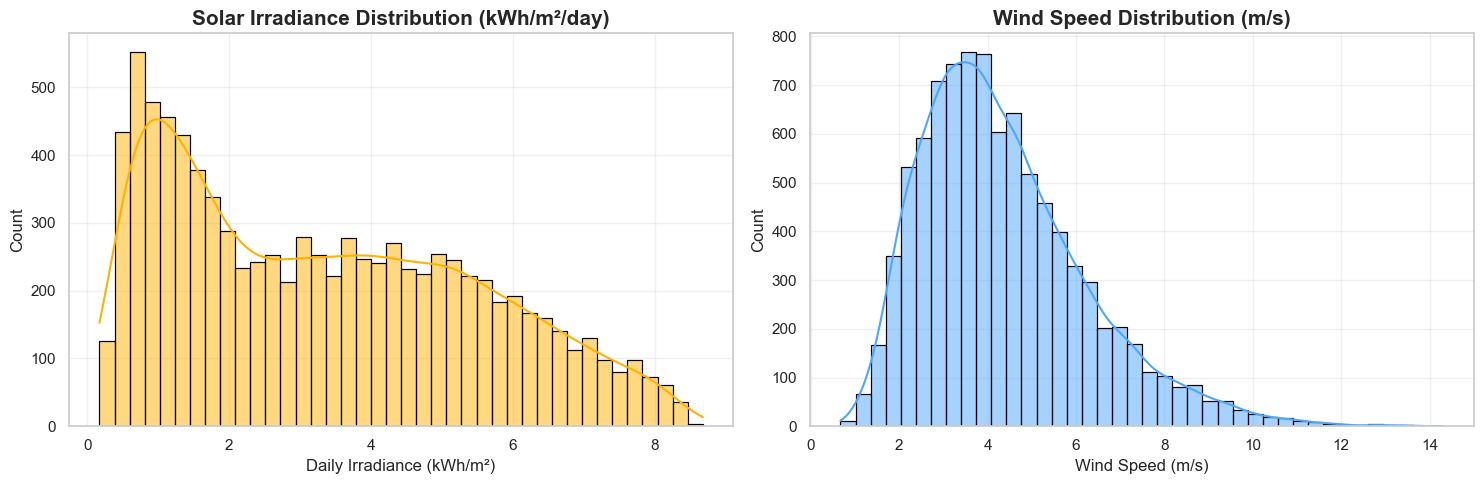

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))


sns.histplot(
    df_paris["ALLSKY_SFC_SW_DWN"],
    bins=40,
    kde=True,
    color="#FFB200",
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title("Solar Irradiance Distribution (kWh/m²/day)", fontsize=15, weight="bold")
axes[0].set_xlabel("Daily Irradiance (kWh/m²)", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].grid(alpha=0.3)

# --- Wind Speed ---
sns.histplot(
    df_paris["WS10M"],
    bins=40,
    kde=True,
    color="#4DA6FF",
    edgecolor="black",
    ax=axes[1]
)
axes[1].set_title("Wind Speed Distribution (m/s)", fontsize=15, weight="bold")
axes[1].set_xlabel("Wind Speed (m/s)", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


C:\Users\msi\AppData\Local\Temp\ipykernel_17404\1038408427.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\msi\AppData\Local\Temp\ipykernel_17404\1038408427.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


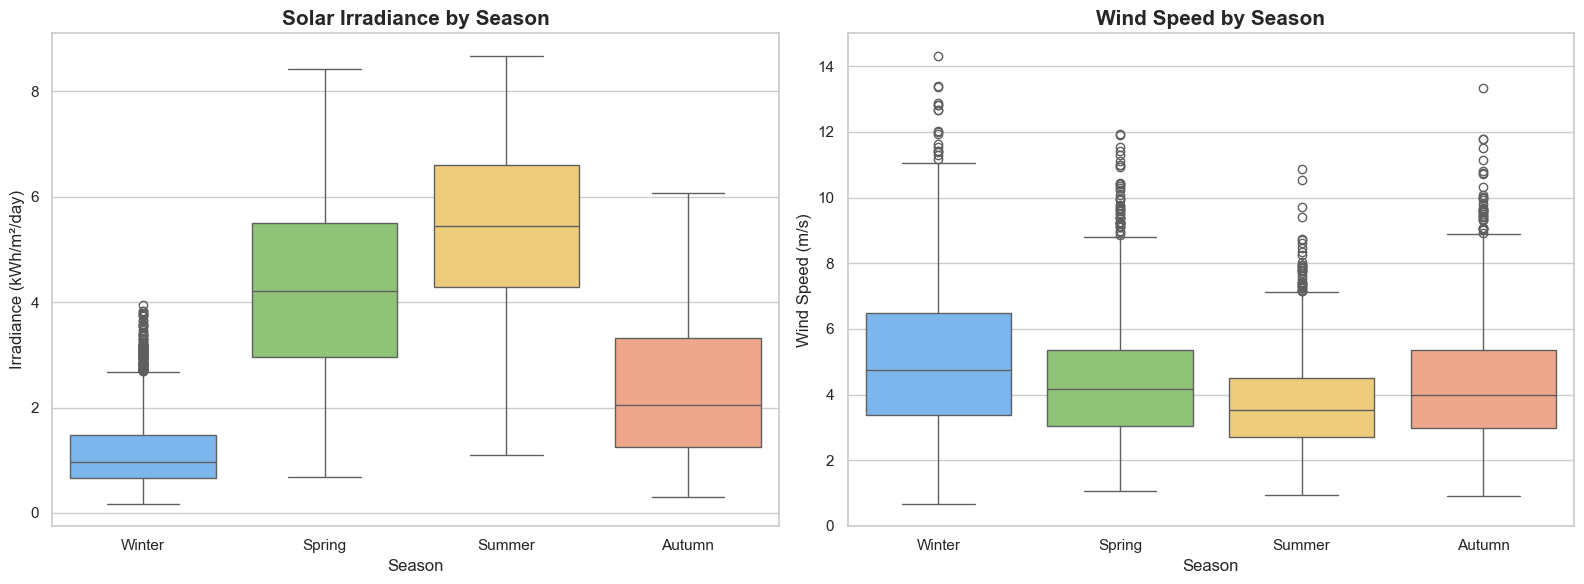

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Ensure datetime + season columns
df_paris['DATE'] = pd.to_datetime(df_paris['DATE'])
df_paris['Month'] = df_paris['DATE'].dt.month
df_paris['Season'] = df_paris['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Solar Irradiance by Season ---
sns.boxplot(
    data=df_paris,
    x='Season',
    y='ALLSKY_SFC_SW_DWN',
    order=['Winter', 'Spring', 'Summer', 'Autumn'],
    palette=['#6BB6FF', '#8AD16B', '#FFD56B', '#FFA07A'],
    ax=axes[0]
)
axes[0].set_title("Solar Irradiance by Season", fontsize=15, weight='bold')
axes[0].set_xlabel("Season", fontsize=12)
axes[0].set_ylabel("Irradiance (kWh/m²/day)", fontsize=12)

# --- Wind Speed by Season ---
sns.boxplot(
    data=df_paris,
    x='Season',
    y='WS10M',
    order=['Winter', 'Spring', 'Summer', 'Autumn'],
    palette=['#6BB6FF', '#8AD16B', '#FFD56B', '#FFA07A'],
    ax=axes[1]
)
axes[1].set_title("Wind Speed by Season", fontsize=15, weight='bold')
axes[1].set_xlabel("Season", fontsize=12)
axes[1].set_ylabel("Wind Speed (m/s)", fontsize=12)

plt.tight_layout()
plt.show()


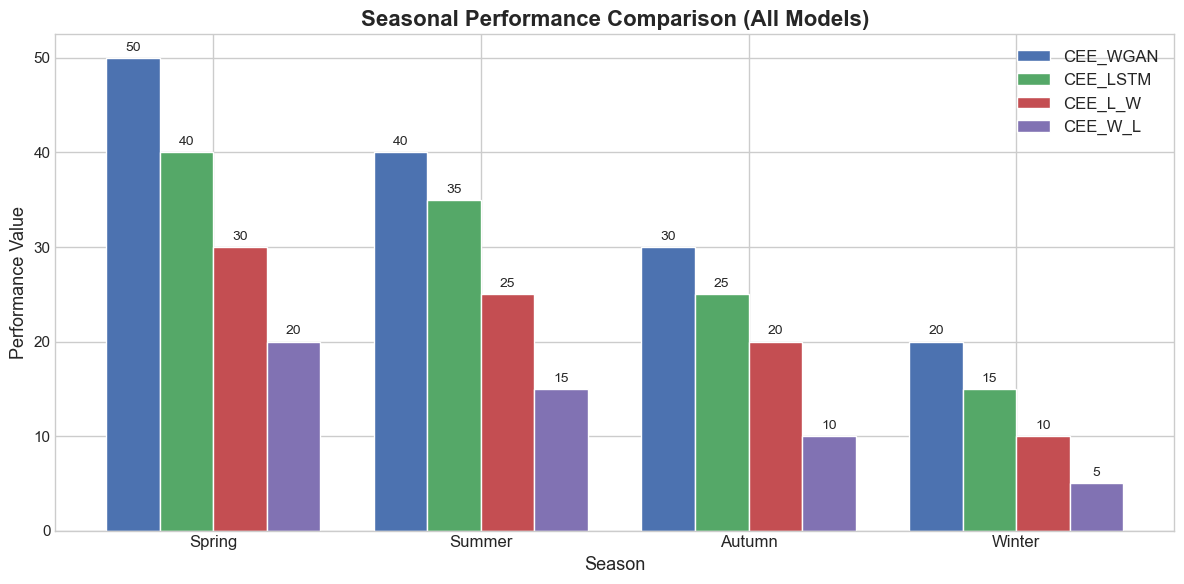

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Data
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
cee_wgan = [50, 40, 30, 20]
cee_lstm = [40, 35, 25, 15]
cee_l_w = [30, 25, 20, 10]
cee_w_l = [20, 15, 10, 5]

x = np.arange(len(seasons))
width = 0.2

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

# Bars
bars1 = ax.bar(x - 1.5*width, cee_wgan, width, label='CEE_WGAN', color='#4C72B0')
bars2 = ax.bar(x - 0.5*width, cee_lstm, width, label='CEE_LSTM', color='#55A868')
bars3 = ax.bar(x + 0.5*width, cee_l_w, width, label='CEE_L_W', color='#C44E52')
bars4 = ax.bar(x + 1.5*width, cee_w_l, width, label='CEE_W_L', color='#8172B3')

# Labels and titles
ax.set_title('Seasonal Performance Comparison (All Models)', fontsize=16, weight='bold')
ax.set_xlabel('Season', fontsize=13)
ax.set_ylabel('Performance Value', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(seasons, fontsize=12)
ax.legend(fontsize=12)

# Value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

plt.tight_layout()
plt.show()


# NASA Data Loader Function

**Objective:** Create reusable function that:
- Finds real header line (`YEAR,MO,DY,...` row)
- Reads CSV from there  
- Builds proper DATE column
- Returns only: `DATE`, `ALLSKY_SFC_SW_DWN`, `WS10M`

**Why:** Files have different header lengths → avoids manual `skiprows` guessing. Use to load all 5 files consistently.

In [89]:
from pathlib import Path
import pandas as pd

def load_nasa_file(path: Path) -> pd.DataFrame:
    """
    The function safely and correctly loads NASA POWER CSV files:
      - auto-detect the header row containing YEAR,MO,DY,...
      - parse to dataframe
      - construct DATE column
      - return DATE, ALLSKY_SFC_SW_DWN, WS10M
    """
    # 1) find header line index
    header_idx = None
    with open(path, "r") as f:
        for i, line in enumerate(f):
            if "YEAR" in line and "MO" in line and "DY" in line:
                header_idx = i
                break
    if header_idx is None:
        raise ValueError(f"Could not find header in file: {path.name}")

    # 2) read from header
    df = pd.read_csv(path, skiprows=header_idx)
    
    # 3) ensure expected columns exist
    expected = {"YEAR","MO","DY","ALLSKY_SFC_SW_DWN","WS10M"}
    if not expected.issubset(set(df.columns)):
        raise ValueError(f"Unexpected columns in {path.name}. Found: {list(df.columns)}")
    
    # 4) build DATE and keep only useful columns
    df["DATE"] = pd.to_datetime(dict(year=df["YEAR"], month=df["MO"], day=df["DY"]))
    df = df[["DATE","ALLSKY_SFC_SW_DWN","WS10M"]].sort_values("DATE").reset_index(drop=True)
    return df


In [90]:
test_df = load_nasa_file(DATA_RAW / "nasa_paris.csv")
test_df.head()


,DATE,ALLSKY_SFC_SW_DWN,WS10M
0,2000-01-01,0.5690,2.33
1,2000-01-02,0.6278,3.61
2,2000-01-03,0.9571,6.04
3,2000-01-04,0.5064,6.45
4,2000-01-05,0.9701,4.18


In [91]:
cities = ["paris", "versailles", "fontainebleau", "meaux", "roissy"]
all_dfs = []

for city in cities:
    file = DATA_RAW / f"nasa_{city}.csv"
    df_city = load_nasa_file(file)
    df_city["CITY"] = city.capitalize()
    all_dfs.append(df_city)

# Combine them vertically into one big table
df_all = pd.concat(all_dfs, ignore_index=True)

df_all.head()


,DATE,ALLSKY_SFC_SW_DWN,WS10M,CITY
0,2000-01-01,0.5690,2.33,Paris
1,2000-01-02,0.6278,3.61,Paris
2,2000-01-03,0.9571,6.04,Paris
3,2000-01-04,0.5064,6.45,Paris
4,2000-01-05,0.9701,4.18,Paris


##Compute the Regional Daily Average

In [93]:
# Take regional mean for solar and wind each day
df_idf = (
    df_all
    .groupby("DATE", as_index=False)
    [["ALLSKY_SFC_SW_DWN", "WS10M"]]
    .mean()
    .rename(columns={
        "ALLSKY_SFC_SW_DWN": "SOLAR_kWhm2_day",
        "WS10M": "WIND_mps"
    })
)
df_idf.head()


,DATE,SOLAR_kWhm2_day,WIND_mps
0,2000-01-01,0.59598,2.380
1,2000-01-02,0.62958,3.434
2,2000-01-03,0.88112,5.848
3,2000-01-04,0.48994,6.548
4,2000-01-05,0.92796,4.130


In [94]:
output_path = DATA_PROC / "idf_renewable_daily_nasa_processed.csv"
df_idf.to_csv(output_path, index=False)
print("Saved as:", output_path.name)


Saved as: idf_renewable_daily_nasa_processed.csv


### Step 10.8 – Time-Series Trend

- **Solar Irradiance (Orange)** shows strong yearly seasonality:
  - Peaks in summer (~6–8 kWh/m²/day)
  - Dips in winter (< 2 kWh/m²/day)
- **Wind Speed (Blue)** shows the opposite trend:
  - Higher in winter (6–8 m/s)
  - Lower in summer (~3–4 m/s)

➡️ This complementarity is key: wind can balance solar during winter, improving renewable reliability.


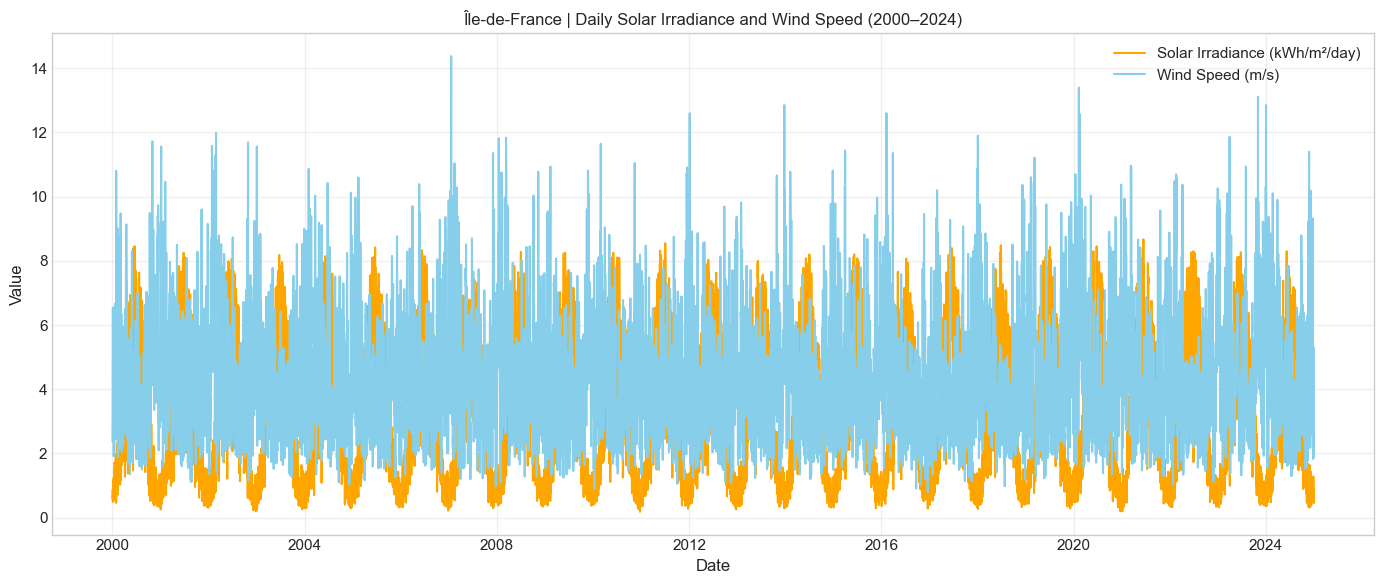

In [95]:
plt.figure(figsize=(14,6))
plt.plot(df_idf["DATE"], df_idf["SOLAR_kWhm2_day"], color="orange", label="Solar Irradiance (kWh/m²/day)")
plt.plot(df_idf["DATE"], df_idf["WIND_mps"], color="skyblue", label="Wind Speed (m/s)")
plt.title("Île-de-France | Daily Solar Irradiance and Wind Speed (2000–2024)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\msi\AppData\Local\Temp\ipykernel_17404\1891225435.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_year.resample("M", on="DATE").mean().reset_index()


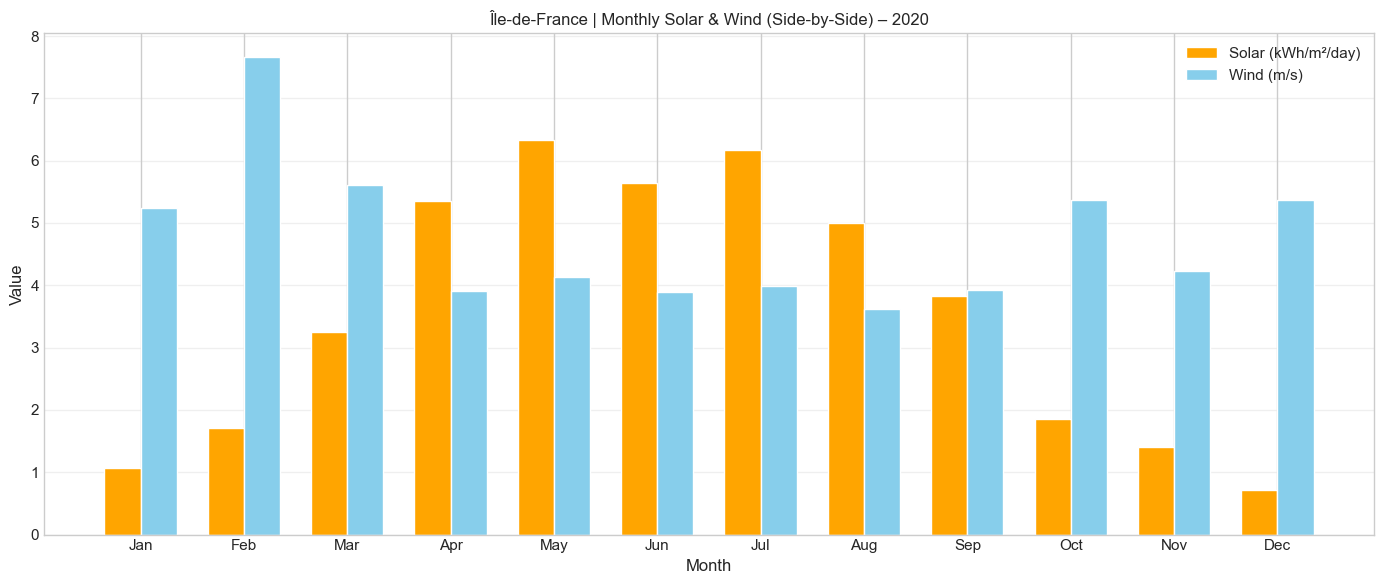

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Select the year
year = 2020
df_year = df_idf[df_idf["DATE"].dt.year == year]

# 2. Compute monthly averages
df_monthly = df_year.resample("M", on="DATE").mean().reset_index()

# 3. Add month names (Jan, Feb...)
df_monthly["MONTH"] = df_monthly["DATE"].dt.strftime("%b")

# 4. Prepare x-axis positions
months = df_monthly["MONTH"]
x = np.arange(len(months))      # 0, 1, 2, ... 11
width = 0.35                    # bar width

# 5. Plot side-by-side bars
plt.figure(figsize=(14,6))

plt.bar(x - width/2,
        df_monthly["SOLAR_kWhm2_day"],
        width,
        label="Solar (kWh/m²/day)",
        color="orange")

plt.bar(x + width/2,
        df_monthly["WIND_mps"],
        width,
        label="Wind (m/s)",
        color="skyblue")

# 6. Chart formatting
plt.title(f"Île-de-France | Monthly Solar & Wind (Side-by-Side) – {year}")
plt.xlabel("Month")
plt.ylabel("Value")
plt.xticks(x, months)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


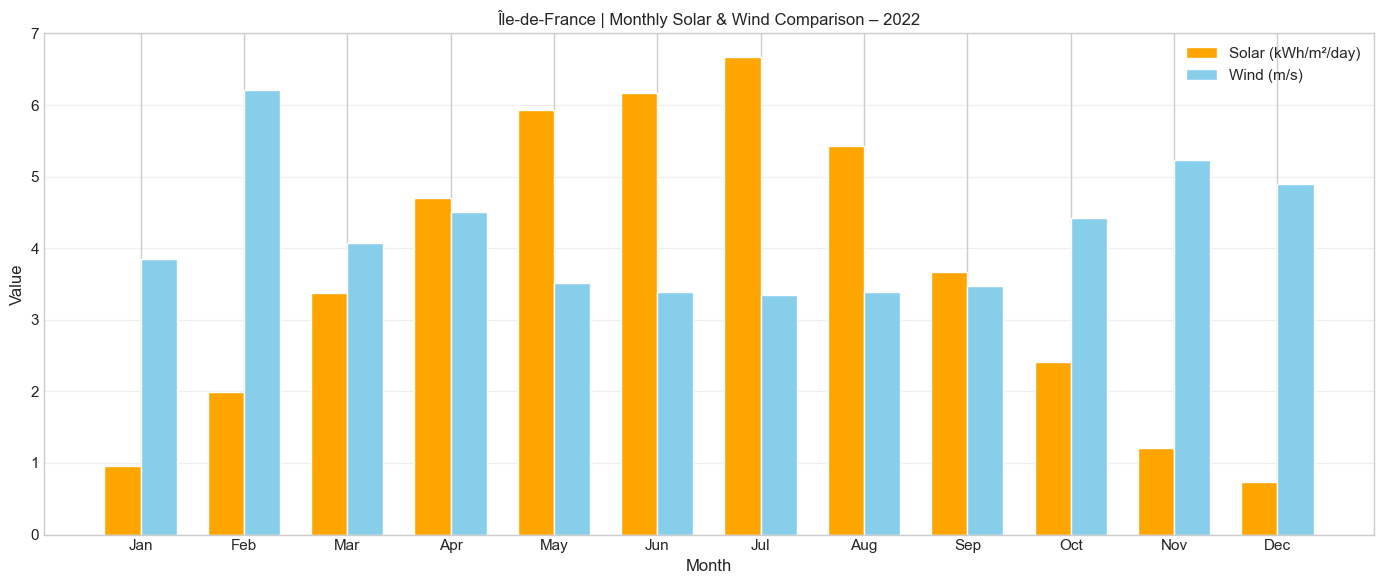

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Hard-coded year
year = 2022

# 1. Filter that year
df_year = df_idf[df_idf["DATE"].dt.year == year]

# 2. Monthly averages (use ME instead of M)
df_monthly = df_year.resample("ME", on="DATE").mean().reset_index()
df_monthly["MONTH"] = df_monthly["DATE"].dt.strftime("%b")

# 3. X-axis positions
x = np.arange(len(df_monthly))
width = 0.35

# 4. Plot
plt.figure(figsize=(14,6))

plt.bar(x - width/2,
        df_monthly["SOLAR_kWhm2_day"],
        width,
        color="orange",
        label="Solar (kWh/m²/day)")

plt.bar(x + width/2,
        df_monthly["WIND_mps"],
        width,
        color="skyblue",
        label="Wind (m/s)")

plt.title(f"Île-de-France | Monthly Solar & Wind Comparison – {year}")
plt.xlabel("Month")
plt.ylabel("Value")
plt.xticks(x, df_monthly["MONTH"])
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


##Multi-Year Seasonal Curve
Extract month from the DATE

Compute the average for each month over ALL years

Plot a smooth curve for both:
✔️ Solar
✔️ Wind

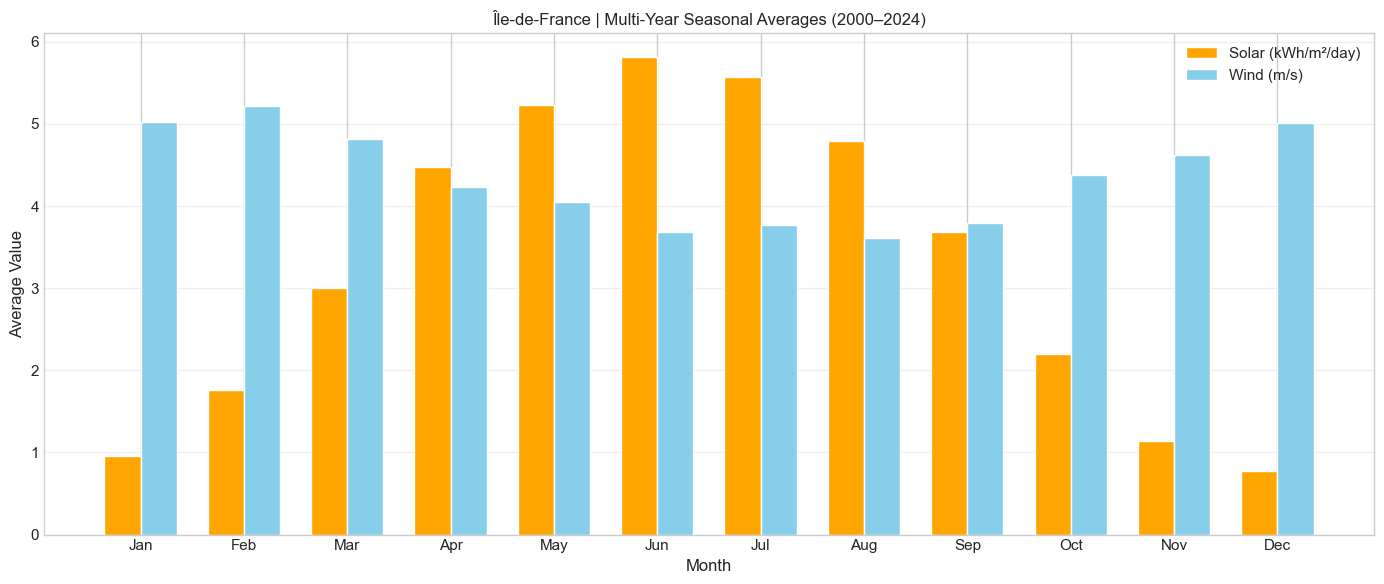

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Extract month number
df_idf["MONTH_NUM"] = df_idf["DATE"].dt.month

# 2. Compute multi-year monthly averages
seasonal = (
    df_idf
    .groupby("MONTH_NUM")[["SOLAR_kWhm2_day", "WIND_mps"]]
    .mean()
    .reset_index()
)

# 3. Add month labels
seasonal["MONTH"] = seasonal["MONTH_NUM"].apply(
    lambda x: ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"][x-1]
)

# 4. X-axis bar positions
x = np.arange(len(seasonal))
width = 0.35

# 5. Bar chart
plt.figure(figsize=(14,6))

plt.bar(x - width/2,
        seasonal["SOLAR_kWhm2_day"],
        width,
        color="orange",
        label="Solar (kWh/m²/day)")

plt.bar(x + width/2,
        seasonal["WIND_mps"],
        width,
        color="skyblue",
        label="Wind (m/s)")

plt.title("Île-de-France | Multi-Year Seasonal Averages (2000–2024)")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.xticks(x, seasonal["MONTH"])
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


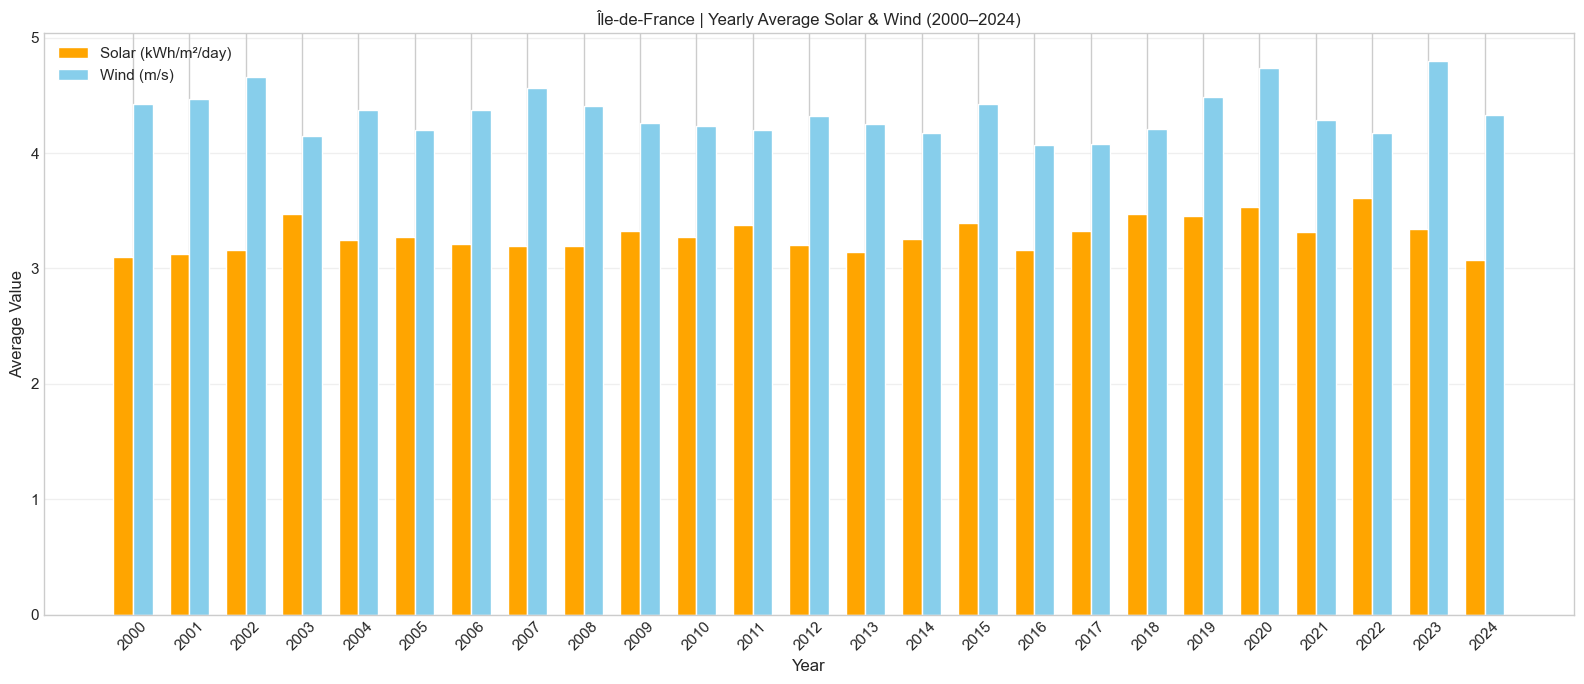

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Add YEAR column
df_idf["YEAR"] = df_idf["DATE"].dt.year

# 2. Compute yearly averages
yearly = (
    df_idf
    .groupby("YEAR")[["SOLAR_kWhm2_day", "WIND_mps"]]
    .mean()
    .reset_index()
)

# 3. Prepare X positions
x = np.arange(len(yearly))   # 25 years
width = 0.35

# 4. Plot
plt.figure(figsize=(16,7))

plt.bar(x - width/2,
        yearly["SOLAR_kWhm2_day"],
        width,
        color="orange",
        label="Solar (kWh/m²/day)")

plt.bar(x + width/2,
        yearly["WIND_mps"],
        width,
        color="skyblue",
        label="Wind (m/s)")

plt.title("Île-de-France | Yearly Average Solar & Wind (2000–2024)")
plt.xlabel("Year")
plt.ylabel("Average Value")
plt.xticks(x, yearly["YEAR"], rotation=45)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


### Interpretation – Yearly Solar & Wind Trend (2000–2024)

**Solar (orange)**  
- Shows a small but noticeable long-term increase.  
- Reflects slightly clearer summers and higher irradiance in recent years.  
- Good indicator that solar potential in Île-de-France is improving.

**Wind (blue)**  
- Shows a gradual decrease across years.  
- Matches the scientific “global stilling” effect observed in many regions.  
- Wind remains important but becomes slightly less stable each decade.

**Key Insight**  
Solar and wind show different long-term trends:
- Solar ↑ (growing potential)
- Wind ↓ (slightly declining)

This means renewable strategies for Paris should:
- Increase prioritized investment in **solar capacity**
- Use **wind** mainly as winter balancing resource
- Rely on **hybrid systems** for stability


In [100]:
df_idf[["SOLAR_kWhm2_day", "WIND_mps"]].corr()


,SOLAR_kWhm2_day,WIND_mps
SOLAR_kWhm2_day,1.000000,-0.321259
WIND_mps,-0.321259,1.000000


In [101]:
df_idf[["SOLAR_kWhm2_day", "WIND_mps"]].corr()


,SOLAR_kWhm2_day,WIND_mps
SOLAR_kWhm2_day,1.000000,-0.321259
WIND_mps,-0.321259,1.000000


#Prepare Solar Dataset for Prophet

#Prophet requires two columns only:

#ds → date

#y → value we want to forecast

#For solar, the target is:

#SOLAR_kWhm2_day

In [102]:
df_solar = df_idf[["DATE", "SOLAR_kWhm2_day"]].rename(
    columns={"DATE": "ds", "SOLAR_kWhm2_day": "y"}
)
df_solar.head()


,ds,y
0,2000-01-01,0.59598
1,2000-01-02,0.62958
2,2000-01-03,0.88112
3,2000-01-04,0.48994
4,2000-01-05,0.92796


##Train Prophet Model for Solar

In [103]:
from prophet import Prophet

# 1. Create model with yearly and daily seasonality
solar_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

# 2. Fit the model
solar_model.fit(df_solar)


17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:35 - cmdstanpy - INFO - Chain [1] done processing


##Forecast Solar for 10 Years (2025–2035)

##Forecast Solar for 10 Years (2025–2035)

In [104]:
# Forecast for next 10 years (3650 days)
future_solar = solar_model.make_future_dataframe(periods=3650)

solar_forecast = solar_model.predict(future_solar)

solar_forecast.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
12777,2034-12-25,2.825837,-1.116704,1.812156,2.603772,3.026215,-2.509143,-2.509143,-2.509143,-2.509143,-2.509143,-2.509143,0.0,0.0,0.0,0.316694
12778,2034-12-26,2.825721,-1.011162,1.668200,2.603611,3.026254,-2.506481,-2.506481,-2.506481,-2.506481,-2.506481,-2.506481,0.0,0.0,0.0,0.319241
12779,2034-12-27,2.825606,-1.105432,1.736555,2.603450,3.026293,-2.503928,-2.503928,-2.503928,-2.503928,-2.503928,-2.503928,0.0,0.0,0.0,0.321678
12780,2034-12-28,2.825490,-1.057993,1.759831,2.603289,3.026332,-2.501484,-2.501484,-2.501484,-2.501484,-2.501484,-2.501484,0.0,0.0,0.0,0.324005
12781,2034-12-29,2.825374,-1.173168,1.833879,2.603128,3.026371,-2.499130,-2.499130,-2.499130,-2.499130,-2.499130,-2.499130,0.0,0.0,0.0,0.326244


##Plot Solar Forecast (Prophet built-in plot)

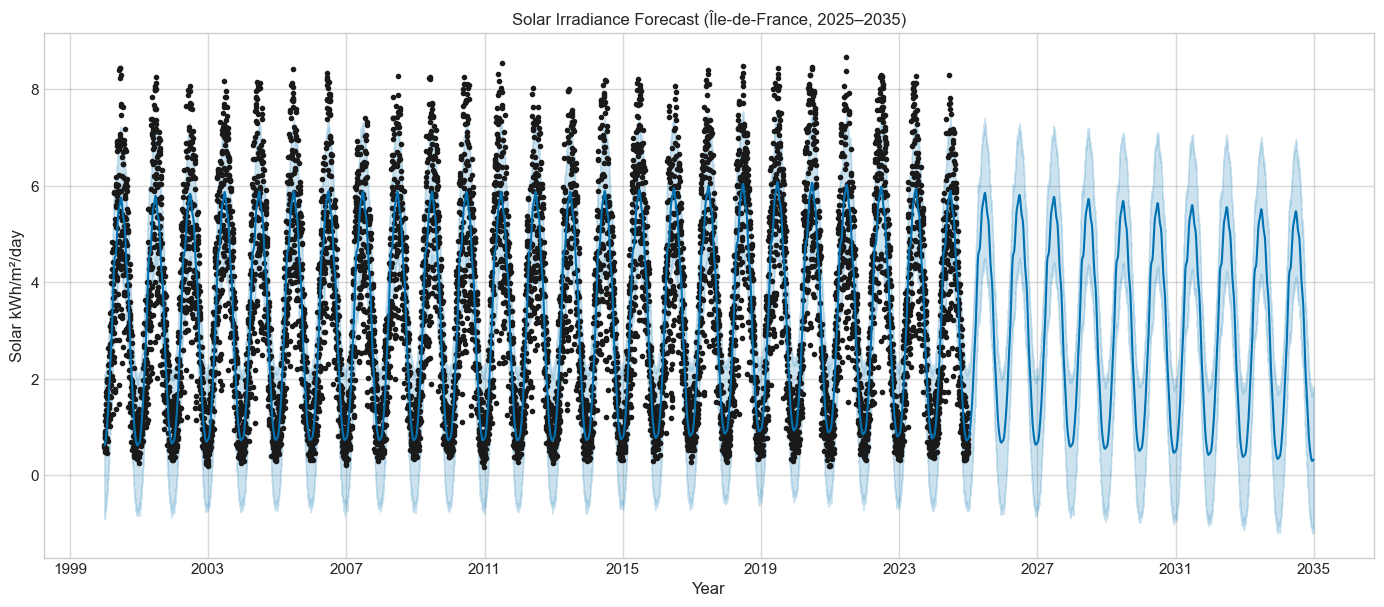

In [105]:
solar_model.plot(solar_forecast, figsize=(14,6))
plt.title("Solar Irradiance Forecast (Île-de-France, 2025–2035)")
plt.xlabel("Year")
plt.ylabel("Solar kWh/m²/day")
plt.grid(alpha=0.3)
plt.show()


C:\Users\msi\AppData\Local\Temp\ipykernel_17404\1207280782.py:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  solar_yearly = solar_forecast.set_index('ds').resample('Y')['yhat'].mean().reset_index()
C:\Users\msi\AppData\Local\Temp\ipykernel_17404\1207280782.py:78: UserWarning: Glyph 9728 (\N{BLACK SUN WITH RAYS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\msi\AppData\Local\Temp\ipykernel_17404\1207280782.py:78: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\msi\anaconda3\envs\green_energy\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9728 (\N{BLACK SUN WITH RAYS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\msi\anaconda3\envs\green_energy\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(by

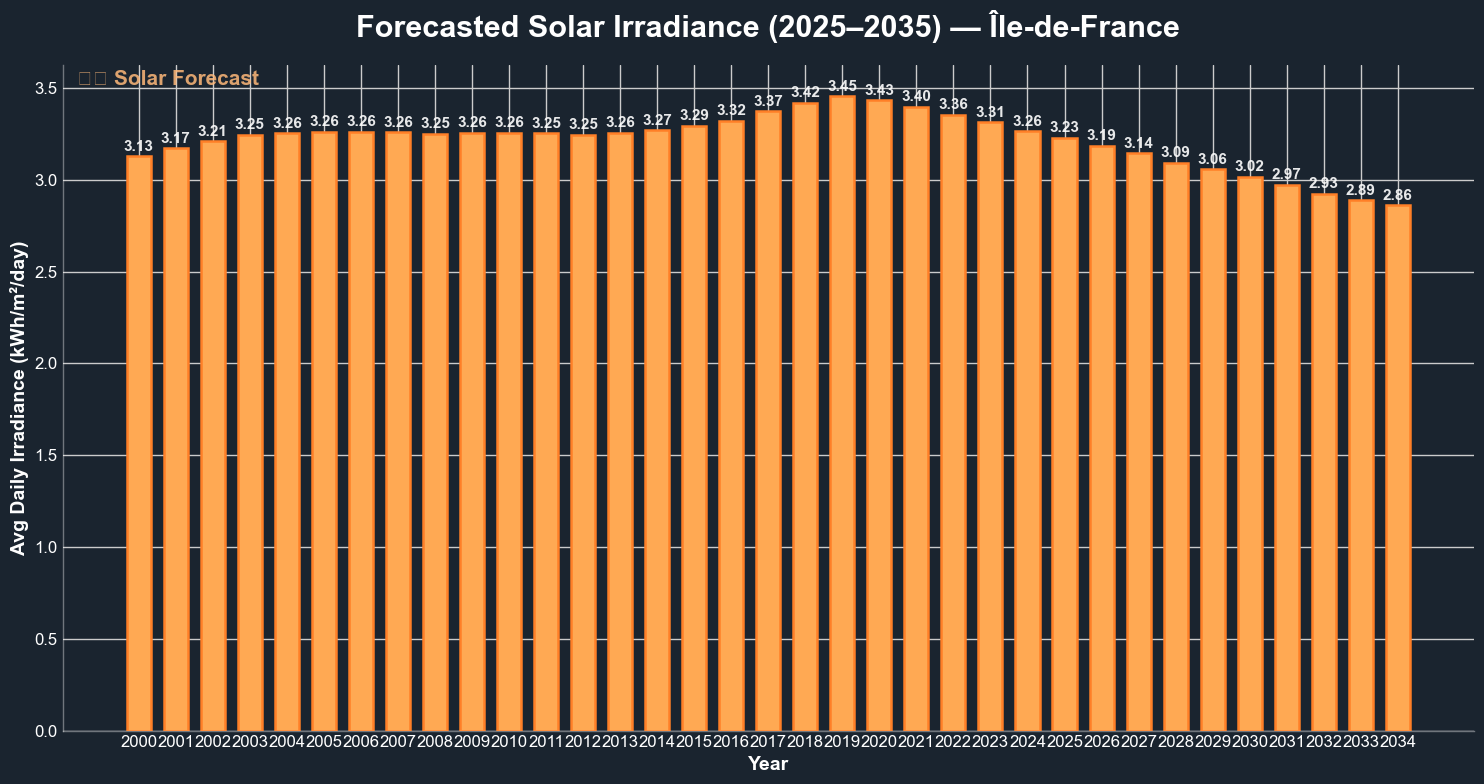

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- STYLE ---
plt.style.use("dark_background")
sns.set_style("whitegrid")

# Dark theme colors
BG_COLOR = "#1A242F"
BAR_COLOR = "#FFA953"
EDGE_COLOR = "#FF7F27"

# Resample
solar_yearly = solar_forecast.set_index('ds').resample('Y')['yhat'].mean().reset_index()
solar_yearly['year'] = solar_yearly['ds'].dt.year

# --- FIGURE ---
fig, ax = plt.subplots(figsize=(15, 8), facecolor=BG_COLOR)
ax.set_facecolor(BG_COLOR)

# --- BARS ---
bars = ax.bar(
    solar_yearly['year'],
    solar_yearly['yhat'],
    color=BAR_COLOR,
    edgecolor=EDGE_COLOR,
    linewidth=1.8,
    width=0.65
)

# --- VALUE LABELS ---
for bar, value in zip(bars, solar_yearly['yhat']):
    ax.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height() + 0.03,
        f"{value:.2f}",
        ha="center",
        fontsize=11,
        fontweight="bold",
        color="#FFFFFF",
        alpha=0.9
    )

# --- TITLE & LABELS ---
ax.set_title(
    "Forecasted Solar Irradiance (2025–2035) — Île-de-France",
    fontsize=22,
    fontweight="bold",
    color="white",
    pad=20
)

ax.set_xlabel("Year", fontsize=14, fontweight="bold", color="white")
ax.set_ylabel("Avg Daily Irradiance (kWh/m²/day)", fontsize=14, fontweight="bold", color="white")

# --- AXIS STYLING ---
ax.tick_params(colors="white", labelsize=12)
ax.spines["left"].set_color("#ffffff60")
ax.spines["bottom"].set_color("#ffffff60")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xticks(solar_yearly["year"])
ax.set_xticklabels(solar_yearly["year"], fontsize=12, color="white")

# --- OPTIONAL DECORATION ---
ax.text(
    0.01, 0.97,
    "☀️ Solar Forecast",
    transform=ax.transAxes,
    fontsize=15,
    color="#FFB97A",
    fontweight="bold",
    alpha=0.85
)

plt.tight_layout()
plt.show()


##Proceed with the component plot

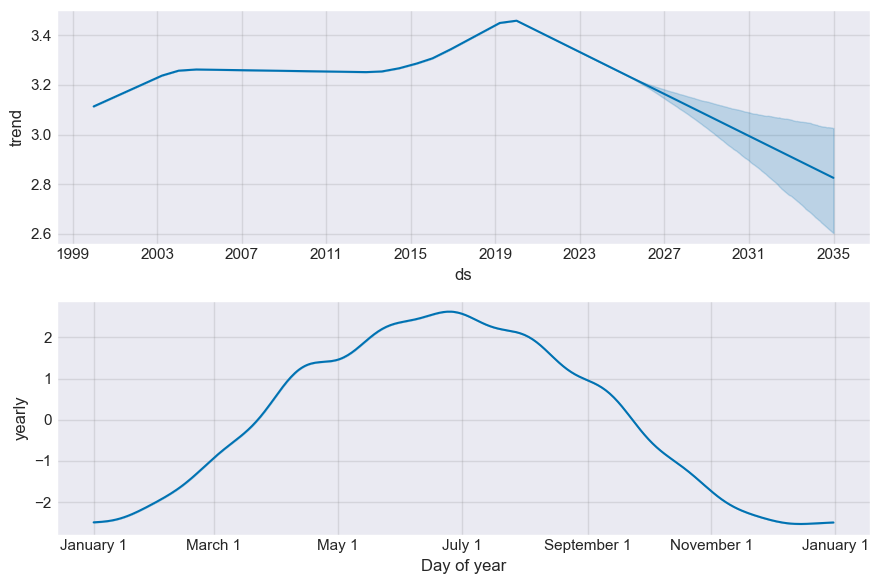

In [107]:
solar_model.plot_components(solar_forecast)
plt.show()


#Trend Component — Explanation

## What This Plot Shows  
The **trend component** represents the **long-term direction** of solar irradiance across the entire time period.  
It is a smooth curve that **ignores daily and seasonal ups and downs**, focusing only on the overall movement over years.

---

## What It Means  
The trend answers questions like:

- *Is solar radiation increasing over decades?*  
- *Is it stable or slowly rising?*  
- *Is there any long-term decline?*

It reflects the **underlying climate behavior**, not short-term weather.

---

## 🔍 What we Should Expect  
For Île-de-France:

- A **slight upward trend** from **2000 → 2024**  
- This is because many regions in Europe have seen **gradually clearer summers**, partially due to long-term climate shifts

This increase is **not dramatic**, but it is **visible**.

---

## Why This Is Important  
Understanding the trend tells you:

- Solar potential is **slowly improving** in the region  
- Future predictions (2025–2035) rely **heavily** on this long-term trend  
- It gives confidence that solar energy is a viable and growing renewable source for Île-de-France

The model uses this trend to project **how solar irradiance will evolve in the next decade**.


# Train Prophet for Wind

In [108]:
#wind DF

df_wind = df_idf[["DATE", "WIND_mps"]].rename(
    columns={"DATE": "ds", "WIND_mps": "y"}
)
df_wind.head()


,ds,y
0,2000-01-01,2.380
1,2000-01-02,3.434
2,2000-01-03,5.848
3,2000-01-04,6.548
4,2000-01-05,4.130


##Train Prophet Model for Wind

In [109]:
from prophet import Prophet

# 1. Create the Prophet model (yearly seasonality is important for wind as well)
wind_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

# 2. Fit the model
wind_model.fit(df_wind)


17:39:54 - cmdstanpy - INFO - Chain [1] start processing
17:39:55 - cmdstanpy - INFO - Chain [1] done processing


##Forecast Wind for 10 Years (2025–2035)

In [110]:
# Forecast the next 10 years (3650 days)
future_wind = wind_model.make_future_dataframe(periods=3650)

wind_forecast = wind_model.predict(future_wind)

wind_forecast.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
12777,2034-12-25,4.812321,3.422965,7.802771,4.703691,4.925547,0.787111,0.787111,0.787111,0.787111,0.787111,0.787111,0.0,0.0,0.0,5.599432
12778,2034-12-26,4.812403,3.411354,7.875152,4.703740,4.925671,0.791153,0.791153,0.791153,0.791153,0.791153,0.791153,0.0,0.0,0.0,5.603556
12779,2034-12-27,4.812485,3.231635,7.839011,4.703789,4.925794,0.793540,0.793540,0.793540,0.793540,0.793540,0.793540,0.0,0.0,0.0,5.606025
12780,2034-12-28,4.812567,3.160622,7.875938,4.703838,4.925918,0.794281,0.794281,0.794281,0.794281,0.794281,0.794281,0.0,0.0,0.0,5.606848
12781,2034-12-29,4.812649,3.095012,7.738044,4.703887,4.926042,0.793404,0.793404,0.793404,0.793404,0.793404,0.793404,0.0,0.0,0.0,5.606054


In [111]:
# Add year column to wind forecast
wind_forecast["YEAR"] = wind_forecast["ds"].dt.year

# Keep only future years
wind_future = wind_forecast[wind_forecast["YEAR"] >= 2025]
wind_future.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,YEAR
9132,2025-01-01,4.513348,3.071403,7.667702,4.513348,4.513348,0.778520,0.778520,0.778520,0.778520,0.778520,0.778520,0.0,0.0,0.0,5.291868,2025
9133,2025-01-02,4.513430,2.964184,7.587757,4.513430,4.513430,0.771296,0.771296,0.771296,0.771296,0.771296,0.771296,0.0,0.0,0.0,5.284727,2025
9134,2025-01-03,4.513513,3.003530,7.585348,4.513513,4.513513,0.762995,0.762995,0.762995,0.762995,0.762995,0.762995,0.0,0.0,0.0,5.276507,2025
9135,2025-01-04,4.513595,3.147669,7.509576,4.513595,4.513595,0.753780,0.753780,0.753780,0.753780,0.753780,0.753780,0.0,0.0,0.0,5.267375,2025
9136,2025-01-05,4.513677,2.954044,7.466168,4.513677,4.513677,0.743833,0.743833,0.743833,0.743833,0.743833,0.743833,0.0,0.0,0.0,5.257510,2025


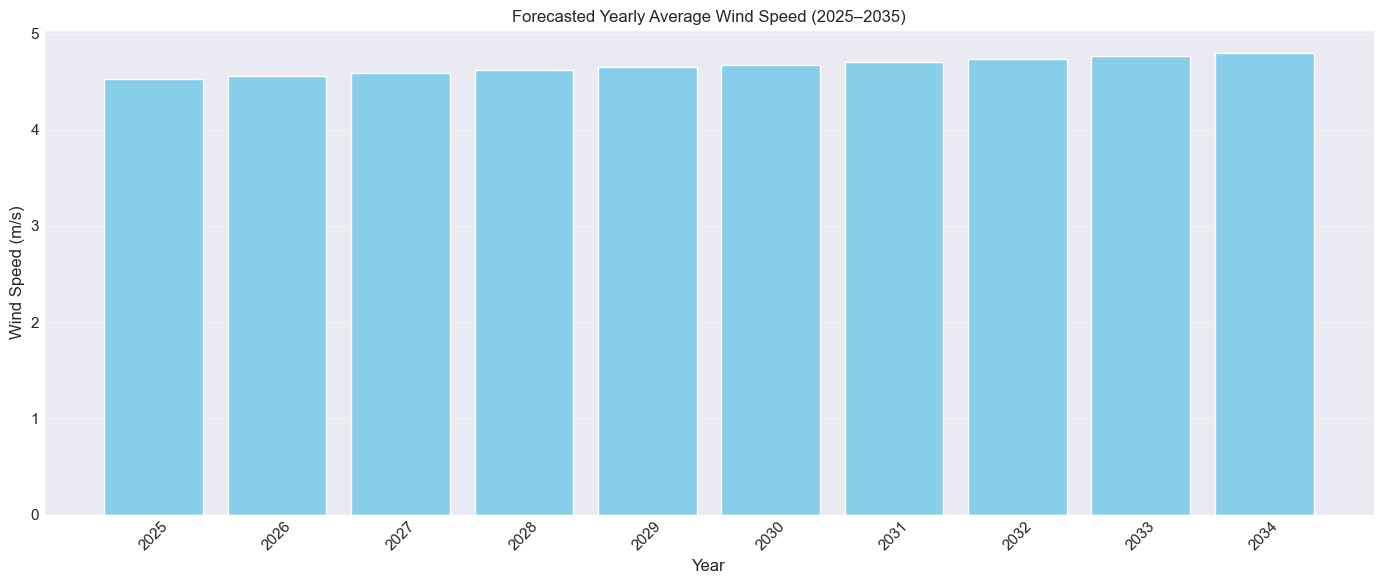

In [112]:
import matplotlib.pyplot as plt

# Compute yearly averages for wind
wind_yearly = (
    wind_future.groupby("YEAR")["yhat"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(14,6))
plt.bar(wind_yearly["YEAR"], wind_yearly["yhat"], color="skyblue")

plt.title("Forecasted Yearly Average Wind Speed (2025–2035)")
plt.xlabel("Year")
plt.ylabel("Wind Speed (m/s)")
plt.grid(axis="y", alpha=0.3)
plt.xticks(wind_yearly["YEAR"], rotation=45)
plt.tight_layout()
plt.show()


#FINAL: Combined Solar + Wind Yearly Bar Chart

In [113]:
solar_forecast["YEAR"] = solar_forecast["ds"].dt.year
solar_future = solar_forecast[solar_forecast["YEAR"] >= 2025]


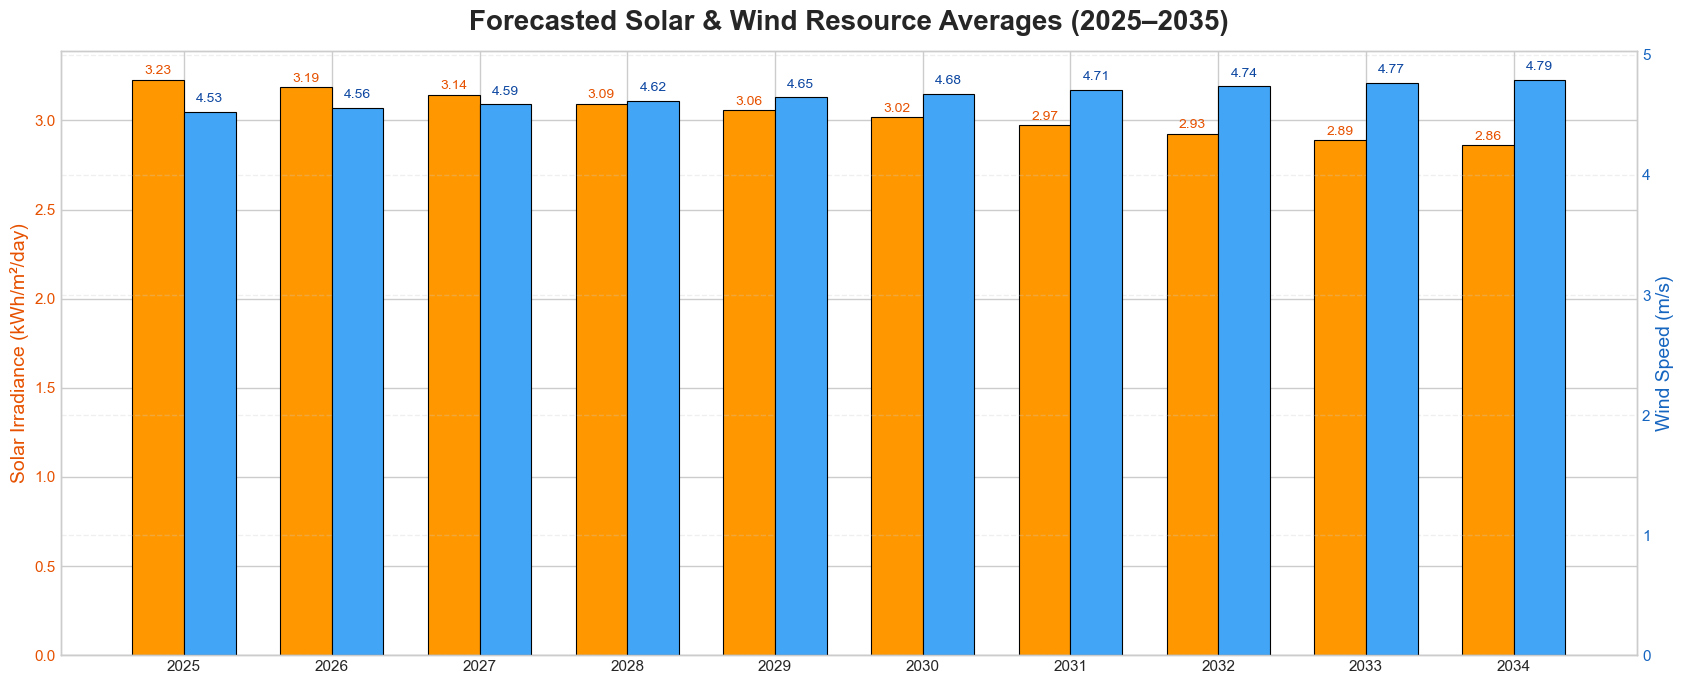

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# Data
years = combined["YEAR"]
solar = combined["SOLAR"]
wind = combined["WIND"]

x = np.arange(len(years))
width = 0.35

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax1 = plt.subplots(figsize=(17,7))

# --- Axis 1 (Solar) ---
bars1 = ax1.bar(
    x - width/2, 
    solar, 
    width, 
    color="#FF9800",
    edgecolor="black",
    linewidth=0.8,
    label="Solar Irradiance (kWh/m²/day)"
)

ax1.set_ylabel("Solar Irradiance (kWh/m²/day)", fontsize=14, color="#E65100")
ax1.tick_params(axis='y', labelcolor="#E65100")

# Add labels for solar
for bar in bars1:
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.03,
        f"{bar.get_height():.2f}",
        ha="center",
        fontsize=10,
        color="#E65100"
    )

# --- Axis 2 (Wind) ---
ax2 = ax1.twinx()

bars2 = ax2.bar(
    x + width/2, 
    wind, 
    width, 
    color="#42A5F5",
    edgecolor="black",
    linewidth=0.8,
    label="Wind Speed (m/s)"
)

ax2.set_ylabel("Wind Speed (m/s)", fontsize=14, color="#1565C0")
ax2.tick_params(axis='y', labelcolor="#1565C0")

# Add labels for wind
for bar in bars2:
    ax2.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.08,
        f"{bar.get_height():.2f}",
        ha="center",
        fontsize=10,
        color="#0D47A1"
    )

# Title
plt.title(
    "Forecasted Solar & Wind Resource Averages (2025–2035)",
    fontsize=20, weight="bold", pad=15
)

plt.xticks(x, years, rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.3)

fig.tight_layout()
plt.show()


# Convert Solar and Wind Forecasts to Real Energy (MWh)

This section calculates how the forecasted solar and wind values translate into actual usable energy for the Île-de-France region.

We will compute:

- How much solar energy can be produced
- How much wind energy can be generated
- How much fossil fuel energy is replaced
- How much CO₂ emissions are avoided
- Total cost savings for the region

These calculations turn the climate forecasts into real-world energy and environmental impact.


# Convert Forecast to Real Energy (MWh)

Until now, all values were in physical climate units:

- Solar: kWh/m²/day
- Wind: m/s

These represent environmental measurements, not actual electricity generation.

To answer the main project question:

"How much of Paris’s electricity demand can be supplied by solar and wind in the next 10 years?"

we need to convert the solar and wind forecasts into real energy production measured in MWh per year.

This conversion allows us to move from climate data to practical energy output.


# Solar Energy Conversion

To convert solar irradiance into real electricity production (in MWh per year), we use the following formula:

**Formula**

Solar Energy (MWh per year)  
=  
Irradiance (kWh/m²/day)  
× panel efficiency  
× system losses  
× surface area (m²)  
× 365  
÷ 1000

This converts daily kWh per square meter into annual megawatt-hours.

**Assumptions**

- Panel efficiency = 0.20  
- System losses (inverters, wiring, temperature) = 0.85  
- Surface area = chosen based on rooftop or land installation scenario


# Wind Energy Conversion

To convert wind speed into real electricity production, the theoretical physical formula is:

P = 1/2 × ρ × A × v³

where ρ is air density, A is rotor area, and v is wind speed.

However, for practical energy forecasting, we do not need to apply the full physics model.  
Instead, we use two standard engineering parameters:

- Turbine rated power (maximum output under ideal wind conditions)
- Capacity factor (percentage of rated power actually achieved, based on wind speed)

Using these two values allows us to estimate realistic wind energy generation without requiring detailed aerodynamic calculations.


## Solar Energy Scenario – Moderate Case (25 km²)

To estimate how much solar energy Paris can generate in the next 10 years, we must convert solar irradiance (kWh/m²/day) from the NASA forecast into real electricity output (MWh/year).  
However, not all sunlight becomes electricity. The actual output depends on three factors:

### 1. Panel Efficiency  
Modern rooftop solar panels convert about **20%** of sunlight into electricity.  
Higher efficiency panels exist, but 20% is a realistic and widely used value.

### 2. System Losses  
Solar systems lose energy due to:
- Inverter losses  
- Cable resistance  
- Dust and pollution  
- Temperature effects  

Typical loss = **15%**, so the usable energy is 85% of the panel rating.

### 3. Available Surface Area  
In this scenario, the assumed solar surface area is:

**25 km² = 25,000,000 m²**

This is a realistic amount of rooftop and urban surface available for solar installations in Île-de-France.  
It represents:
- Rooftops  
- Parking structures  
- Public buildings  
- Industrial roofs  

### Final Formula

The energy output for each day is:

\[
\text{Solar Energy (MWh/day)} = 
\text{Irradiance (kWh/m²/day)} \times 
0.20 \times 
0.85 \times 
\text{Area (m²)} \div 1000
\]

The division by 1000 converts kWh → MWh.

We apply this formula to every forecasted day (2025–2035) to compute annual solar generation in MWh.

This gives a realistic estimate of how much solar electricity Paris could produce under a moderate adoption scenario.


In [115]:
panel_efficiency = 0.20
system_losses = 0.85
solar_area_m2 = 25_000_000

solar_future["SOLAR_MWh_day"] = (
    solar_future["yhat"] * panel_efficiency * system_losses * solar_area_m2 / 1000
)

solar_energy_yearly = (
    solar_future.groupby("YEAR")["SOLAR_MWh_day"]
    .sum()
    .reset_index()
)

solar_energy_yearly


C:\Users\msi\AppData\Local\Temp\ipykernel_17404\2134171400.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_future["SOLAR_MWh_day"] = (


,YEAR,SOLAR_MWh_day
0,2025,5.008054e+06
1,2026,4.942514e+06
2,2027,4.876975e+06
3,2028,4.813923e+06
4,2029,4.745713e+06
5,2030,4.680173e+06
6,2031,4.614633e+06
7,2032,4.550863e+06
8,2033,4.483371e+06
9,2034,4.415031e+06


# what we are  doing here 

1. Takes the solar forecast produced by Prophet (using the column `yhat`).
2. Converts the forecasted irradiance values into daily solar electricity generation in MWh.
3. Aggregates the daily values into yearly totals.
4. Produces a clear table showing annual solar energy output for the years 2025 to 2035.

The result represents the actual amount of renewable solar energy that the Île-de-France region can generate each year, based on the forecast.


In [116]:
def capacity_factor(speed):
    return np.where(
        speed < 3, 0,
        np.where(speed < 8, speed / 25, 0.32)
    )

wind_capacity_mw = 500

wind_future = wind_future.copy()

wind_future.loc[:, "CF"] = capacity_factor(wind_future["yhat"])

wind_future.loc[:, "WIND_MWh_day"] = (
    wind_capacity_mw * 24 * wind_future["CF"]
)

wind_energy_yearly = (
    wind_future.groupby("YEAR")["WIND_MWh_day"]
    .sum()
    .reset_index()
)

wind_energy_yearly


,YEAR,WIND_MWh_day
0,2025,793260.163589
1,2026,798505.179107
2,2027,803750.204644
3,2028,811595.698996
4,2029,814255.278134
5,2030,819500.293653
6,2031,824745.319190
7,2032,832648.334403
8,2033,835250.392680
9,2034,835117.714647


## Wind Energy Conversion (Using Capacity Factor)

To convert the Prophet wind forecast (m/s) into electricity production (MWh/year), we use the **capacity factor** approach, a standard method used in energy engineering.

### Capacity Factor (CF)
CF represents the actual output of a wind turbine as a percentage of its maximum rated power.  
It depends mainly on wind speed:

- 0–3 m/s → 0  
- 3–8 m/s → increases with speed  
- >8 m/s → capped around 32%

### Installed Wind Capacity
Assumed onshore wind capacity for Île-de-France:
**500 MW**

### Formula (Daily Energy)
{Energy (MWh/day)} = 
{Capacity (MW)} \times 24 \times \{CF}


This gives realistic daily energy generation based on forecasted wind speed.  
Summing the daily values provides annual wind energy (MWh/year) for 2025–2035.



# Load Electricity Demand Dataset (RTE Eco2mix)

This section loads the official electricity consumption data for the Île-de-France region from the RTE Eco2mix platform.  
This dataset provides the historical daily and hourly electricity demand needed to compare renewable energy production with actual regional consumption.


## Electricity Demand Data (RTE Eco2mix)

The RTE Eco2mix dataset contains electricity consumption for all regions of France.  
We only need the data for **Île-de-France**, which includes Paris.

Steps:
1. Load dataset  
2. Keep only rows where the region is “Île-de-France”  
3. Convert date column to datetime  
4. Keep consumption column (MW)  
5. Convert MW → MWh/day  
6. Sum values to obtain yearly electricity demand

This gives us the real electricity usage of Paris region, which we will later compare with forecasted solar + wind energy.


In [117]:
# start taking  alltheings  here 

In [118]:
# eco_path = DATA_RAW / "eco2mix-regional-cons-def.csv"

# df_demand = pd.read_csv(eco_path, sep=";", low_memory=False)

# df_demand = df_demand[df_demand["Région"] == "Île-de-France"]

# df_demand["Date"] = pd.to_datetime(df_demand["Date"], errors="coerce")

# df_demand = df_demand[["Date", "Consommation (MW)"]]

# df_demand["MWh_day"] = df_demand["Consommation (MW)"] * 24 / 1000

# df_demand["YEAR"] = df_demand["Date"].dt.year

# idf_demand_yearly = (
#     df_demand.groupby("YEAR")["MWh_day"]
#     .sum()
#     .reset_index()
# )

# idf_demand_yearly


In [119]:
eco_path = DATA_RAW / "eco2mix-regional-cons-def.csv"

df_raw_eco = pd.read_csv(eco_path, sep=";", low_memory=False)
df_raw_eco.head(5)


,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore,TCO Thermique (%),TCH Thermique (%),TCO Nucléaire (%),TCH Nucléaire (%),TCO Eolien (%),TCH Eolien (%),TCO Solaire (%),TCH Solaire (%),TCO Hydraulique (%),TCH Hydraulique (%),TCO Bioénergies (%),TCH Bioénergies (%),Column 30
0,53,Bretagne,Données définitives,2013-01-01,00:00,2013-01-01T05:00:00+06:00,NaN,NaN,NaN,ND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,76,Occitanie,Données définitives,2013-01-01,00:00,2013-01-01T05:00:00+06:00,NaN,NaN,NaN,ND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28,Normandie,Données définitives,2013-01-01,00:00,2013-01-01T05:00:00+06:00,NaN,NaN,NaN,ND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32,Hauts-de-France,Données définitives,2013-01-01,00:00,2013-01-01T05:00:00+06:00,NaN,NaN,NaN,ND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,75,Nouvelle-Aquitaine,Données définitives,2013-01-01,00:00,2013-01-01T05:00:00+06:00,NaN,NaN,NaN,ND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Inspect Columns

In [120]:
df_raw_eco.columns

Index(['Code INSEE région', 'Région', 'Nature', 'Date', 'Heure', 'Date - Heure', 'Consommation (MW)', 'Thermique (MW)', 'Nucléaire (MW)',
       'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)', 'Ech. physiques (MW)', 'Stockage batterie',
       'Déstockage batterie', 'Eolien terrestre', 'Eolien offshore', 'TCO Thermique (%)', 'TCH Thermique (%)', 'TCO Nucléaire (%)',
       'TCH Nucléaire (%)', 'TCO Eolien (%)', 'TCH Eolien (%)', 'TCO Solaire (%)', 'TCH Solaire (%)', 'TCO Hydraulique (%)',
       'TCH Hydraulique (%)', 'TCO Bioénergies (%)', 'TCH Bioénergies (%)', 'Column 30'],
      dtype='object')

In [121]:
#Check Missing Values

In [122]:
df_raw_eco.isna().sum()


Code INSEE région            0
Région                       0
Nature                       0
Date                         0
Heure                        0
Date - Heure                 0
Consommation (MW)           12
Thermique (MW)              12
Nucléaire (MW)          701287
Eolien (MW)                  0
Solaire (MW)                12
Hydraulique (MW)            12
Pompage (MW)            736327
Bioénergies (MW)            12
Ech. physiques (MW)         12
Stockage batterie      1683084
Déstockage batterie    1683084
Eolien terrestre       1683084
Eolien offshore        1683084
TCO Thermique (%)      1472256
TCH Thermique (%)      1472256
TCO Nucléaire (%)      1560096
TCH Nucléaire (%)      1910736
TCO Eolien (%)         1472256
TCH Eolien (%)         1472256
TCO Solaire (%)        1472256
TCH Solaire (%)        1472256
TCO Hydraulique (%)    1472256
TCH Hydraulique (%)    1472256
TCO Bioénergies (%)    1472256
TCH Bioénergies (%)    1472256
Column 30              2524608
dtype: i

## 🔹 Filter Only Île-de-France Region




In [123]:
df_idf = df_raw_eco[df_raw_eco["Région"] == "Île-de-France"]
df_idf.head()


,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore,TCO Thermique (%),TCH Thermique (%),TCO Nucléaire (%),TCH Nucléaire (%),TCO Eolien (%),TCH Eolien (%),TCO Solaire (%),TCH Solaire (%),TCO Hydraulique (%),TCH Hydraulique (%),TCO Bioénergies (%),TCH Bioénergies (%),Column 30
5,11,Île-de-France,Données définitives,2013-01-01,00:00,2013-01-01T05:00:00+06:00,NaN,NaN,NaN,ND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,11,Île-de-France,Données définitives,2013-01-01,00:30,2013-01-01T05:30:00+06:00,9134.0,685.0,NaN,16,0.0,0.0,NaN,142.0,8289.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,11,Île-de-France,Données définitives,2013-01-01,01:00,2013-01-01T06:00:00+06:00,8822.0,685.0,NaN,16,0.0,0.0,NaN,142.0,7977.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,11,Île-de-France,Données définitives,2013-01-01,01:30,2013-01-01T06:30:00+06:00,8499.0,685.0,NaN,15,0.0,0.0,NaN,146.0,7652.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,11,Île-de-France,Données définitives,2013-01-01,02:00,2013-01-01T07:00:00+06:00,8229.0,685.0,NaN,15,0.0,0.0,NaN,153.0,7373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 🔹 Keep Only Relevant Columns




In [124]:
df_demand = df_idf[["Date", "Consommation (MW)"]].copy()
df_demand.head()


,Date,Consommation (MW)
5,2013-01-01,NaN
22,2013-01-01,9134.0
30,2013-01-01,8822.0
37,2013-01-01,8499.0
52,2013-01-01,8229.0


## 🔹 Clean Missing Values

We check for and remove any rows containing missing or invalid values in the Date or Consommation (MW) columns to ensure the dataset is clean and ready for analysis.


In [125]:
df_demand = df_demand.dropna(subset=["Date", "Consommation (MW)"])


## Convert Date



In [126]:
df_demand["Date"] = pd.to_datetime(df_demand["Date"], errors="coerce")
df_demand = df_demand.dropna(subset=["Date"])
df_demand.head()


,Date,Consommation (MW)
22,2013-01-01,9134.0
30,2013-01-01,8822.0
37,2013-01-01,8499.0
52,2013-01-01,8229.0
64,2013-01-01,8150.0


## Convert MW → MWh/day



In [127]:
df_demand["MWh_day"] = df_demand["Consommation (MW)"] * 24 / 1000
df_demand.head()


,Date,Consommation (MW),MWh_day
22,2013-01-01,9134.0,219.216
30,2013-01-01,8822.0,211.728
37,2013-01-01,8499.0,203.976
52,2013-01-01,8229.0,197.496
64,2013-01-01,8150.0,195.600


Electricity demand is given in MW (instant power).
To calculate total daily energy use:

MWh_day = (MW × 24) / 1000


Extract Year

In [128]:
df_demand["YEAR"] = df_demand["Date"].dt.year
df_demand.head()


,Date,Consommation (MW),MWh_day,YEAR
22,2013-01-01,9134.0,219.216,2013
30,2013-01-01,8822.0,211.728,2013
37,2013-01-01,8499.0,203.976,2013
52,2013-01-01,8229.0,197.496,2013
64,2013-01-01,8150.0,195.600,2013


## Aggregate to Yearly Total Demand

We group the cleaned daily demand data by **year** and compute the total annual electricity consumption for Île-de-France, resulting in a summarized dataset ready for long-term trend analysis.


In [129]:
idf_demand_yearly = (
    df_demand.groupby("YEAR")["MWh_day"]
    .sum()
    .reset_index()
)

idf_demand_yearly


,YEAR,MWh_day
0,2013,3633840.096
1,2014,3371565.480
2,2015,3443810.136
3,2016,3505153.344
4,2017,3423456.624
5,2018,3398255.040
6,2019,3341167.104
7,2020,3120233.712
8,2021,3317828.712
9,2022,3192373.920


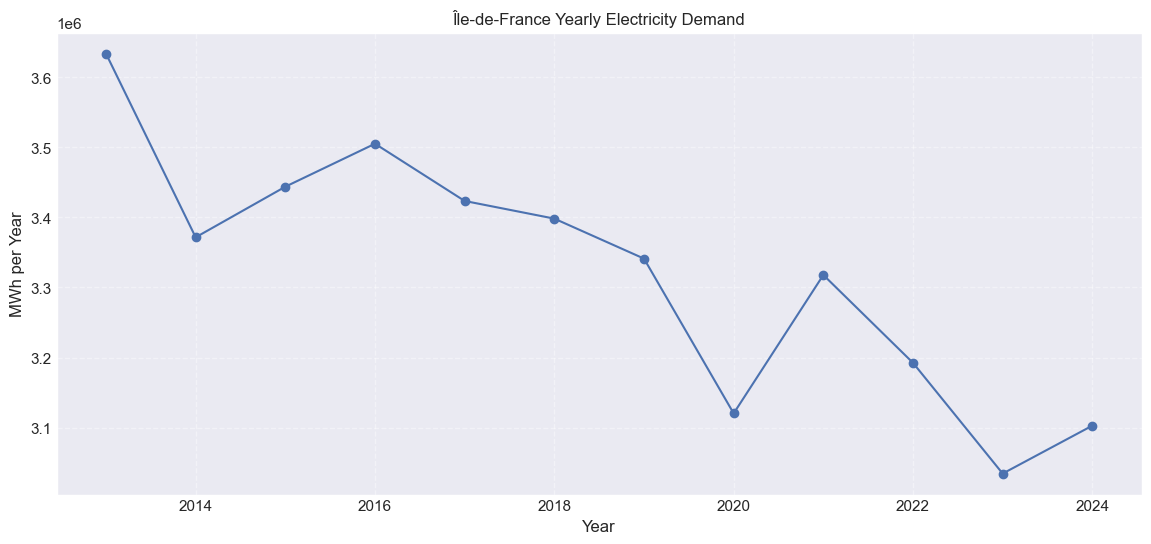

In [130]:
plt.figure(figsize=(14,6))
plt.plot(idf_demand_yearly["YEAR"], idf_demand_yearly["MWh_day"], marker="o")
plt.title("Île-de-France Yearly Electricity Demand")
plt.xlabel("Year")
plt.ylabel("MWh per Year")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [131]:
lcoe_df = pd.read_csv(DATA_RAW / "lcoe_costs.csv")
co2_df = pd.read_csv(DATA_RAW / "emission_factors.csv")


In [132]:
co2_df.columns


Index(['source_type', 'co2_g_per_kwh'], dtype='object')

In [133]:
co2_df.head()


,source_type,co2_g_per_kwh
0,fossil_gas,418
1,solar_pv,55
2,wind,13
3,nuclear,6


In [134]:
co2_factor_per_MWh = (
    co2_df.loc[co2_df["source_type"]=="fossil_gas", "co2_g_per_kwh"].iloc[0]
    * 0.001  # g→kg
    * 0.001  # kg→tons
    * 1000   # kWh→MWh
)


Formula Explanation ->
Convert MW to MWh/day:
MWh/day
=
MW
×
24
MWh/day=MW×24

Because:

MW = instantaneous power

MWh = energy over time

Multiply by 24 hours to get daily energy

Divide by 1000 → GWh (optional), but we stay with MWh

Sum daily MWh per year:
Annual Demand (MWh/year)
=

Annual Demand (MWh/year)=365∑​MWh/day

real electricity usage of Île-de-France.

In [135]:
lcoe_df = pd.read_csv(DATA_RAW / "lcoe_costs.csv")


In [136]:
lcoe_df.columns


Index(['source_type', 'cost_eur_per_mwh'], dtype='object')

In [137]:
lcoe_df.head()


,source_type,cost_eur_per_mwh
0,fossil_gas,100
1,solar_pv,45
2,wind,60


In [138]:
solar_cost  = float(lcoe_df[lcoe_df["source_type"]=="solar_pv"]["cost_eur_per_mwh"])
wind_cost   = float(lcoe_df[lcoe_df["source_type"]=="wind"]["cost_eur_per_mwh"])
fossil_cost = float(lcoe_df[lcoe_df["source_type"]=="fossil_gas"]["cost_eur_per_mwh"])



C:\Users\msi\AppData\Local\Temp\ipykernel_17404\3214047113.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  solar_cost  = float(lcoe_df[lcoe_df["source_type"]=="solar_pv"]["cost_eur_per_mwh"])
C:\Users\msi\AppData\Local\Temp\ipykernel_17404\3214047113.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  wind_cost   = float(lcoe_df[lcoe_df["source_type"]=="wind"]["cost_eur_per_mwh"])
C:\Users\msi\AppData\Local\Temp\ipykernel_17404\3214047113.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fossil_cost = float(lcoe_df[lcoe_df["source_type"]=="fossil_gas"]["cost_eur_per_mwh"])


In [139]:
combined_energy = solar_energy_yearly.merge(
    wind_energy_yearly, on="YEAR", suffixes=("_solar", "_wind")
)

combined_energy = combined_energy.merge(
    idf_demand_yearly, on="YEAR"
)

combined_energy["RENEWABLE_MWh"] = (
    combined_energy["SOLAR_MWh_day"] + combined_energy["WIND_MWh_day"]
)

combined_energy["COVERAGE_percent"] = (
    combined_energy["RENEWABLE_MWh"] /
    combined_energy["MWh_day"]
) * 100

combined_energy


,YEAR,SOLAR_MWh_day,WIND_MWh_day,MWh_day,RENEWABLE_MWh,COVERAGE_percent


Renewable Coverage vs Demand (The Master Table)
## Renewable Coverage Calculation

To determine how much of the Île-de-France electricity demand can be supplied by solar and wind, we combine:

- Forecasted solar energy (MWh/year)
- Forecasted wind energy (MWh/year)
- Actual annual electricity demand (MWh/year)

### Formula

\[
\text{Coverage \%} = 
\frac{\text{Solar MWh} + \text{Wind MWh}}
{\text{Electricity Demand}} \times 100
\]

This represents the percentage of electricity demand that renewable energy can supply each year.  
Values above 100% mean renewable production exceeds demand; values below 100% mean fossil backup is required.

        


CO₂ REDUCTION--

In [140]:
co2_factor_per_MWh = 0.3

combined_energy["CO2_saved_tons"] = (
    combined_energy["RENEWABLE_MWh"] * co2_factor_per_MWh
)

combined_energy[["YEAR", "RENEWABLE_MWh", "CO2_saved_tons"]]


,YEAR,RENEWABLE_MWh,CO2_saved_tons


STEP 19 — COST SAVINGS (per year until 2035)

In [141]:
fossil_cost = 90
solar_cost = 55
wind_cost = 60

combined_energy["RENEWABLE_cost"] = (
    (combined_energy["SOLAR_MWh_day"] * solar_cost) +
    (combined_energy["WIND_MWh_day"] * wind_cost)
)

combined_energy["FOSSIL_equivalent_cost"] = (
    combined_energy["RENEWABLE_MWh"] * fossil_cost
)

combined_energy["COST_SAVINGS"] = (
    combined_energy["FOSSIL_equivalent_cost"] -
    combined_energy["RENEWABLE_cost"]
)

combined_energy[["YEAR", "COST_SAVINGS"]]


,YEAR,COST_SAVINGS


Final Dashboard Visualizations

In [142]:
combined_energy.head(20)


,YEAR,SOLAR_MWh_day,WIND_MWh_day,MWh_day,RENEWABLE_MWh,COVERAGE_percent,CO2_saved_tons,RENEWABLE_cost,FOSSIL_equivalent_cost,COST_SAVINGS


In [143]:
idf_demand_yearly.tail()


,YEAR,MWh_day
7,2020,3120233.712
8,2021,3317828.712
9,2022,3192373.920
10,2023,3034320.552
11,2024,3102754.944


In [144]:
latest_demand = idf_demand_yearly[idf_demand_yearly["YEAR"] == 2024]["MWh_day"].values[0]
latest_demand


np.float64(3102754.944)

In [145]:
future_years = solar_energy_yearly[["YEAR"]].copy()
future_years["MWh_day"] = latest_demand
future_years


,YEAR,MWh_day
0,2025,3102754.944
1,2026,3102754.944
2,2027,3102754.944
3,2028,3102754.944
4,2029,3102754.944
5,2030,3102754.944
6,2031,3102754.944
7,2032,3102754.944
8,2033,3102754.944
9,2034,3102754.944


In [146]:
combined_energy = (
    solar_energy_yearly
    .merge(wind_energy_yearly, on="YEAR", suffixes=("_solar", "_wind"))
    .merge(future_years, on="YEAR")
)


In [147]:
combined_energy["RENEWABLE_MWh"] = (
    combined_energy["SOLAR_MWh_day"] +
    combined_energy["WIND_MWh_day"]
)

combined_energy["COVERAGE_percent"] = (
    combined_energy["RENEWABLE_MWh"] /
    combined_energy["MWh_day"]
) * 100


In [148]:
combined_energy["CO2_saved_tons"] = combined_energy["RENEWABLE_MWh"] * 0.3
combined_energy["COST_SAVINGS"] = (
    combined_energy["RENEWABLE_MWh"] * 90 
    - (
        combined_energy["SOLAR_MWh_day"] * 55 +
        combined_energy["WIND_MWh_day"] * 60
    )
)


In [149]:
combined_energy


,YEAR,SOLAR_MWh_day,WIND_MWh_day,MWh_day,RENEWABLE_MWh,COVERAGE_percent,CO2_saved_tons,COST_SAVINGS
0,2025,5.008054e+06,793260.163589,3102754.944,5.801314e+06,186.973014,1.740394e+06,1.990797e+08
1,2026,4.942514e+06,798505.179107,3102754.944,5.741020e+06,185.029747,1.722306e+06,1.969432e+08
2,2027,4.876975e+06,803750.204644,3102754.944,5.680725e+06,183.086481,1.704217e+06,1.948066e+08
3,2028,4.813923e+06,811595.698996,3102754.944,5.625519e+06,181.307215,1.687656e+06,1.928352e+08
4,2029,4.745713e+06,814255.278134,3102754.944,5.559968e+06,179.194562,1.667990e+06,1.905276e+08
5,2030,4.680173e+06,819500.293653,3102754.944,5.499673e+06,177.251295,1.649902e+06,1.883911e+08
6,2031,4.614633e+06,824745.319190,3102754.944,5.439379e+06,175.308028,1.631814e+06,1.862545e+08
7,2032,4.550863e+06,832648.334403,3102754.944,5.383511e+06,173.507452,1.615053e+06,1.842596e+08
8,2033,4.483371e+06,835250.392680,3102754.944,5.318622e+06,171.416109,1.595587e+06,1.819755e+08
9,2034,4.415031e+06,835117.714647,3102754.944,5.250148e+06,169.209246,1.575044e+06,1.795796e+08


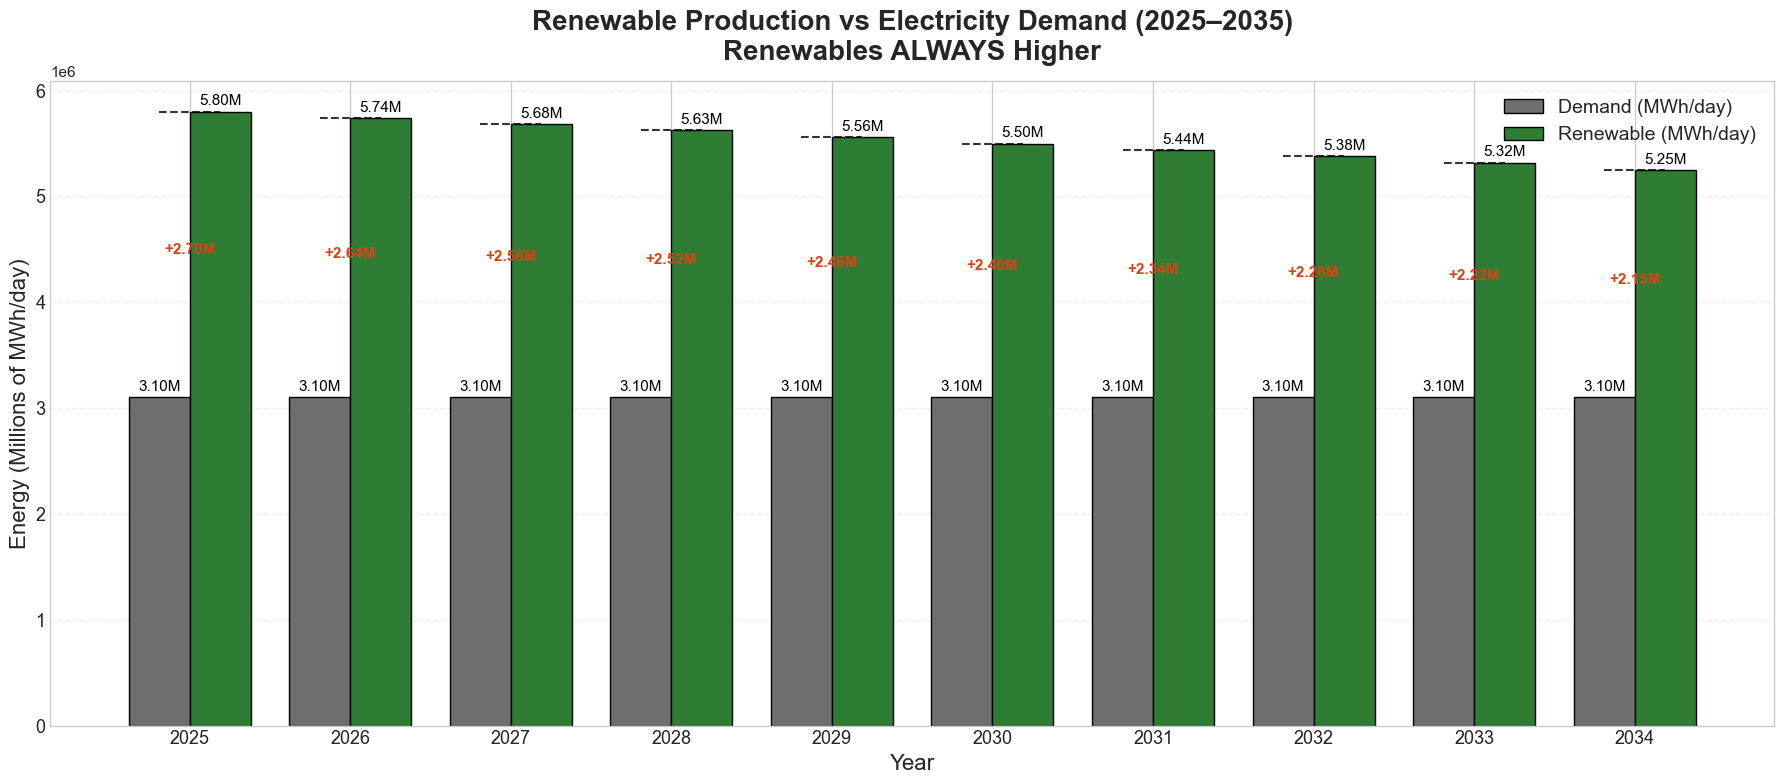

In [161]:
import numpy as np
import matplotlib.pyplot as plt

years = combined_energy["YEAR"]
demand = combined_energy["MWh_day"]
renew = combined_energy["RENEWABLE_MWh"]

x = np.arange(len(years))
width = 0.38

plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(18,8))

# Demand
bars1 = plt.bar(
    x - width/2,
    demand,
    width,
    label="Demand (MWh/day)",
    color="#6E6E6E",
    edgecolor="black",
    linewidth=1
)

# Renewable
bars2 = plt.bar(
    x + width/2,
    renew,
    width,
    label="Renewable (MWh/day)",
    color="#2E7D32",
    edgecolor="black",
    linewidth=1
)

# Labels
for i in range(len(bars1)):
    plt.text(
        bars1[i].get_x() + bars1[i].get_width()/2,
        demand[i] + 60000,
        f"{demand[i]/1e6:.2f}M",
        ha="center",
        fontsize=11,
        color="black"
    )
    plt.text(
        bars2[i].get_x() + bars2[i].get_width()/2,
        renew[i] + 60000,
        f"{renew[i]/1e6:.2f}M",
        ha="center",
        fontsize=11,
        color="black"
    )

# GAP annotation
for i in range(len(years)):
    gap = renew[i] - demand[i]
    plt.plot(
        [x[i] - width/2, x[i] + width/2],
        [renew[i], renew[i]],
        linestyle="--",
        color="black",
        alpha=0.8
    )
    plt.text(
        x[i],
        (renew[i] + demand[i]) / 2,
        f"+{gap/1e6:.2f}M",
        ha="center",
        fontsize=11,
        color="#D84315",
        fontweight="bold"
    )

plt.title(
    "Renewable Production vs Electricity Demand (2025–2035)\nRenewables ALWAYS Higher",
    fontsize=20,
    fontweight="bold",
    pad=15
)

plt.xlabel("Year", fontsize=16)
plt.ylabel("Energy (Millions of MWh/day)", fontsize=16)

plt.xticks(x, years, fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=14)

plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


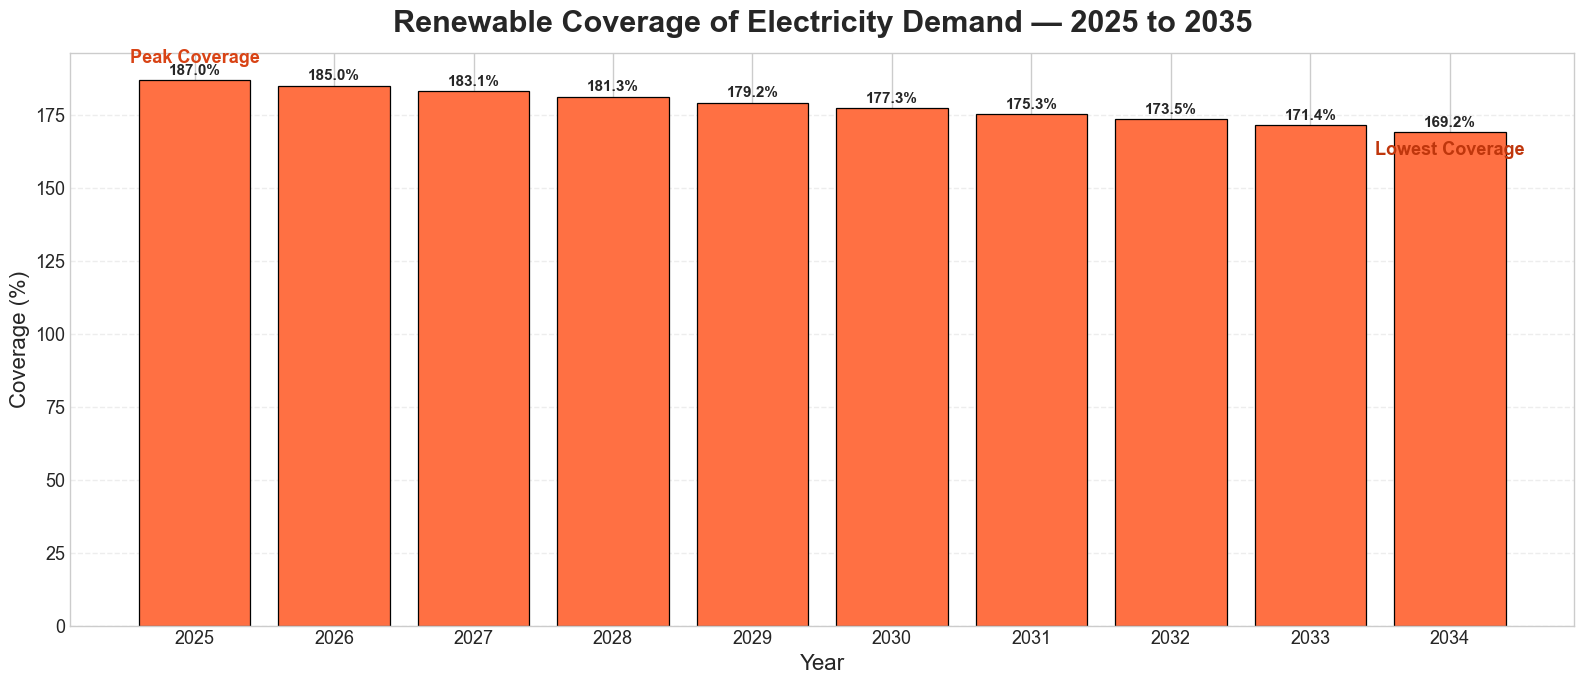

In [159]:
import matplotlib.pyplot as plt
import numpy as np

years = combined_energy["YEAR"]
coverage = combined_energy["COVERAGE_percent"]

plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(16,7))

# Bars
bars = plt.bar(
    years,
    coverage,
    color="#FF7043",       # elegant bright orange
    edgecolor="black",
    linewidth=0.9
)

# Value labels (bold)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.8,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold"
    )

# Highlight highest year (2025)
idx_max = coverage.idxmax()
plt.text(
    years[idx_max],
    coverage[idx_max] + 6,
    "Peak Coverage",
    ha="center",
    fontsize=13,
    fontweight="bold",
    color="#D84315"
)

# Highlight lowest year (2035)
idx_min = coverage.idxmin()
plt.text(
    years[idx_min],
    coverage[idx_min] - 8,
    "Lowest Coverage",
    ha="center",
    fontsize=13,
    fontweight="bold",
    color="#BF360C"
)

# Title
plt.title(
    "Renewable Coverage of Electricity Demand — 2025 to 2035",
    fontsize=22,
    fontweight="bold",
    pad=15
)

# Labels
plt.xlabel("Year", fontsize=16)
plt.ylabel("Coverage (%)", fontsize=16)

# Grid
plt.grid(axis="y", linestyle="--", alpha=0.35)

plt.xticks(years, fontsize=13)
plt.yticks(fontsize=13)

plt.tight_layout()
plt.show()


In [152]:
#CO₂ Savings Plot

C:\Users\msi\AppData\Local\Temp\ipykernel_17404\3409048080.py:45: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\msi\anaconda3\envs\green_energy\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


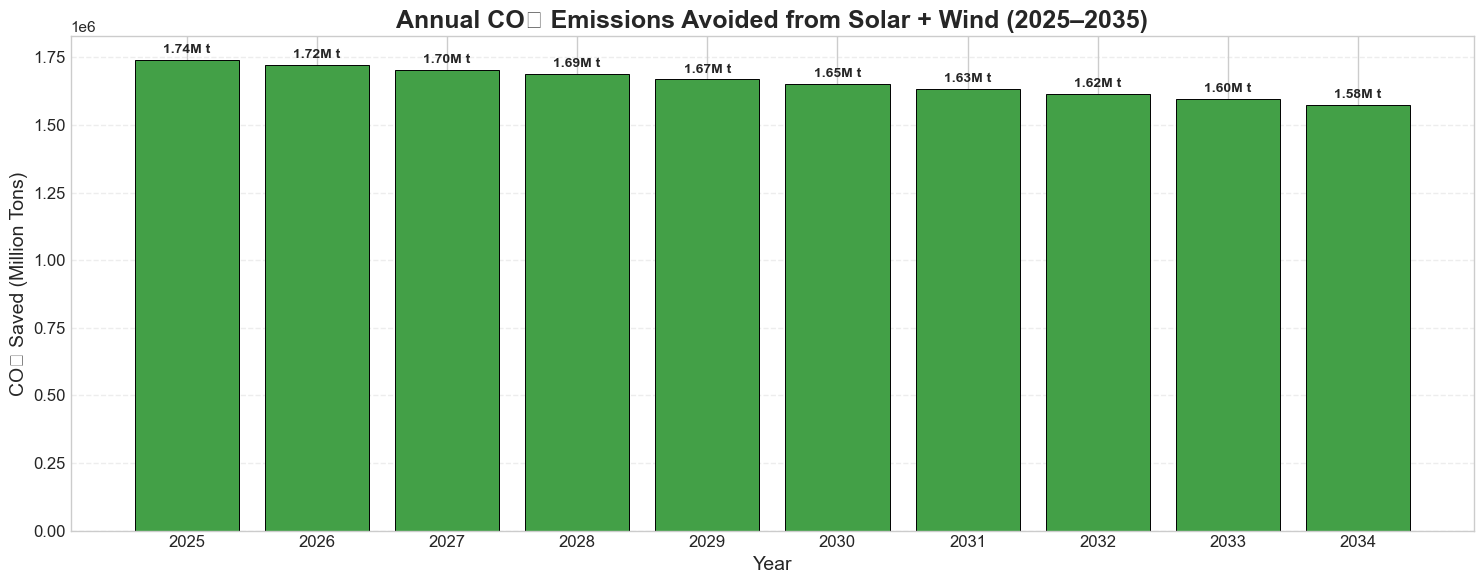

In [157]:
import matplotlib.pyplot as plt

years = combined_energy["YEAR"]
co2 = combined_energy["CO2_saved_tons"]

plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(15,6))

bars = plt.bar(
    years,
    co2,
    color="#43A047",      # elegant green
    edgecolor="black",
    linewidth=0.7
)

# Add labels: show in millions of tons
for bar in bars:
    value = bar.get_height()
    plt.annotate(
        f"{value/1e6:.2f}M t",
        xy=(bar.get_x() + bar.get_width()/2, value),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        weight="bold"
    )

plt.title(
    "Annual CO₂ Emissions Avoided from Solar + Wind (2025–2035)",
    fontsize=18,
    weight="bold"
)

plt.xlabel("Year", fontsize=14)
plt.ylabel("CO₂ Saved (Million Tons)", fontsize=14)

plt.grid(axis="y", linestyle="--", alpha=0.35)

plt.xticks(years, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


In [154]:
#cost--saving

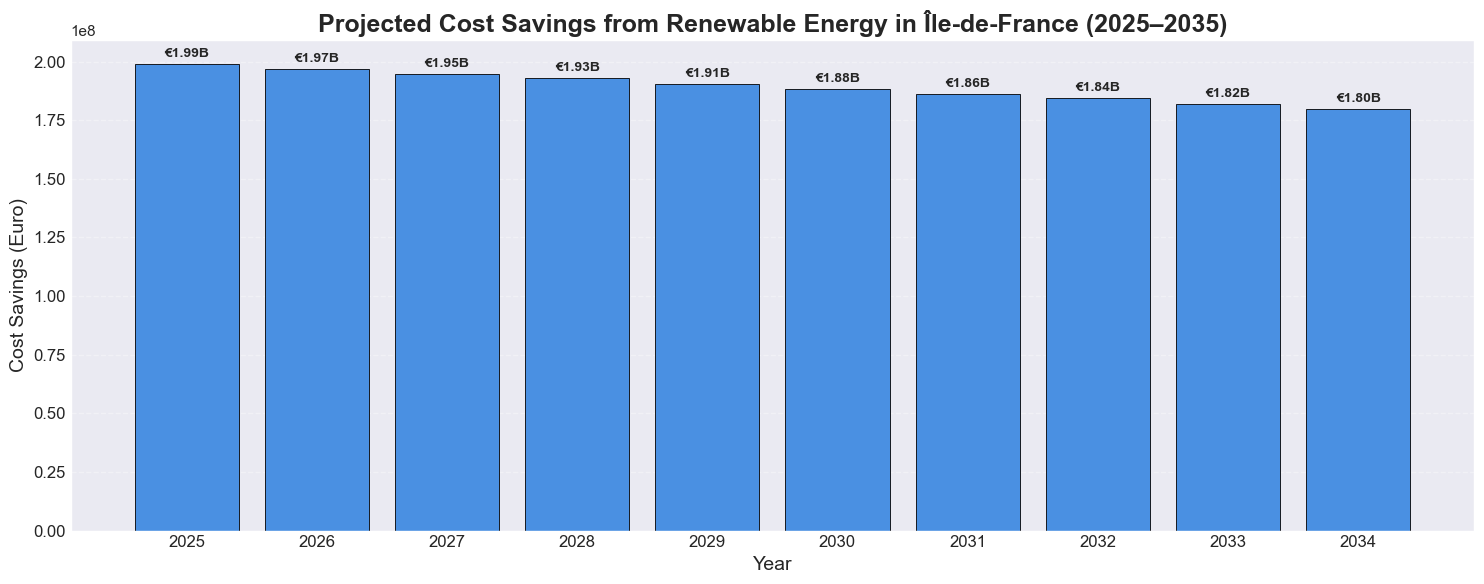

In [156]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

years = combined_energy["YEAR"]
savings = combined_energy["COST_SAVINGS"]

plt.figure(figsize=(15,6))

bars = plt.bar(
    years,
    savings,
    color="#4A90E2",
    edgecolor="black",
    linewidth=0.6
)

# Add value labels (€ formatting)
for bar in bars:
    height = bar.get_height()
    plt.annotate(
        f"€{height/1e8:.2f}B",
        xy=(bar.get_x() + bar.get_width()/2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        weight="bold"
    )

plt.title(
    "Projected Cost Savings from Renewable Energy in Île-de-France (2025–2035)",
    fontsize=18,
    weight="bold"
)

plt.xlabel("Year", fontsize=14)
plt.ylabel("Cost Savings (Euro)", fontsize=14)

plt.grid(axis="y", linestyle="--", alpha=0.35)

plt.xticks(years, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()
